In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import math
import time
import matplotlib as mpl

import os
cwd = os.getcwd()

%run compare_loglike

In [2]:
# define variables
delta_t = 0.3

#T=60 gives 200 Y
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5])
log_Lambda = np.log(Lambda)
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50.0

n_param = 5

parameter_names = ['v1', 'v2', 'loglambda1', 'loglambda2', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log($\lambda_1$)',
                       r'log($\lambda_2$)', r'$\sigma$']

theta_true = list(V) + list(log_Lambda) + [sigma] #not including values for P for 2x2

In [3]:
#THIS STILL NEEDS TO BE MODIFIED FOR SEVERAL CASES
def get_parameters(theta):
    V = np.zeros(2)
    V[0] = 1.0*theta[0]
    V[1] = 1.0*theta[1]
    Lambda = 1.0*np.exp(np.array(theta[2:4]))
    P = np.zeros((2,2))
    P[0,1] = 1.0
    P[1,0] = 1.0
    sigma = 1.0*theta[-1]
    
    return V, Lambda, P, sigma

def theta_init_true(seed):
    
    theta = np.array(theta_true)
    #print('theta_init =', get_parameters(theta))
    return theta

In [4]:
def compute_loglikelihood(N_part, nr_iterations, Y, theta=theta_true, delta_t=delta_t,
                          get_parameters=get_parameters, ret_time=False):
    
    print('Number of iterations', nr_iterations)
    loglike = np.zeros(nr_iterations)
    
    start = time.time()
    for seed in range(nr_iterations):
        loglike[seed] = log_pi_hat(theta, get_parameters, N_part=N_part,
                                   delta_t=delta_t,
                                   Yt=Y, seed=seed)
    end = time.time()

    print('Time required', end-start, 'seconds')
    
    if ret_time:
        return loglike, end-start
    
    return loglike

In [5]:
def compute_approx_loglikelihood(dY, theta=theta_true, delta_t=delta_t, ret_time=False):
    
    V, Lambda, P, sigma = get_parameters(theta)
    start = time.time()
    like = approx_pdf_track_up_to_1_switch(V, Lambda, P, sigma, delta_t, dY)
    end = time.time()

    print('Runtime', end-start, 'seconds')
    loglike = np.sum(np.log(like))
    
    if ret_time:
        return loglike, end-start
    
    return loglike

In [6]:
def compare(T, init_seed, N_part, nr_iterations, theta=theta_true, theta_true=theta_true):
    data_seed = 3001+4999*init_seed
    N_datapoints = int(T/0.3)
    print('Datapoints', N_datapoints)
    print('N_part', N_part)
    i = 0
    Y = get_data_Ys(delta_t = delta_t, T = T, theta = theta_true,
                    get_parameters = get_parameters, seed = data_seed+5099*i)
    #print('\n\nY =', Y)
    y_sim = np.array([0]+list(Y))
    dY = np.array([y_sim[i]-y_sim[i-1] for i in range(1,y_sim.shape[0])])

    #pMCMC
    print('\npMCMC')
    LpMCMC = compute_loglikelihood(N_part=N_part, nr_iterations=nr_iterations,
                                   Y=Y, theta=theta)
    print(LpMCMC)
    print('Max loglike', np.max(LpMCMC))
    n_inf = 100*(list(LpMCMC).count(-math.inf)/nr_iterations)
    print('Result -inf is', n_inf, '%', )
    #my approx
    print('\nTrack approximation')
    ltrack = compute_approx_loglikelihood(dY=dY, theta=theta)
    print(ltrack)
    return LpMCMC, ltrack, n_inf

In [7]:
def compare_time(T, init_seed, N_part, nr_iterations, theta=theta_true,
                 theta_true=theta_true):
    data_seed = 3001+4999*init_seed
    N_datapoints = int(T/0.3)
    print('Datapoints', N_datapoints)
    print('N_part', N_part)
    i = 0
    Y = get_data_Ys(delta_t = delta_t, T = T, theta = theta_true,
                    get_parameters = get_parameters, seed = data_seed+5099*i)
    #print('\n\nY =', Y)
    y_sim = np.array([0]+list(Y))
    dY = np.array([y_sim[i]-y_sim[i-1] for i in range(1,y_sim.shape[0])])
    #pMCMC
    TpMCMC = compute_loglikelihood(N_part=N_part, nr_iterations=nr_iterations,
                                   Y=Y, theta=theta,
                                   ret_time=True)[1]
    #my approx
    Ttrack = compute_approx_loglikelihood(dY=dY, theta=theta, ret_time=True)[1]
    return TpMCMC, Ttrack

In [8]:
save_for_varying_part = [None for _ in range(50)]
for n_particle in range(1,51):
    save_for_varying_part[n_particle-1] = compare(T=60, init_seed=0,
                                                  N_part=n_particle, nr_iterations=1000)

Datapoints 200
N_part 1

pMCMC
Number of iterations 1000
Time required 0.4402029514312744 seconds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf

Time required 3.280478000640869 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  

Time required 6.31737208366394 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  -8303.39248128
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf   

Time required 8.82177996635437 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -7550.25765109            -inf -12318.7853817             -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  -9006.89274921
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf   

Time required 13.408705711364746 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -9006.30452694            -inf -13337.47928897            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf -12081.32486749
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf -32936.66222385            -inf            -inf
 -25503.18371693            -inf            -inf            -inf
 -37175.20822683            -inf            -inf -15808.0701613
 -26491.56667832            -inf            -inf  

Time required 18.567046880722046 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf -12212.03794419            -inf
            -inf -12367.07788516 -20291.23509594            -inf
            -inf            -inf            -inf -11062.57599342
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
 -40190.44090288            -inf            -inf            -inf
            -inf -23786.57127076            -inf            -inf
 -18555.04328799            -inf            -inf            -inf
 -31024.96611329            -inf            -inf            -inf
            -inf            -inf            -inf 

Time required 24.342814922332764 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf -16626.09381572
 -14997.40498107            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -4856.45423753            -inf            -inf  -6741.47578313
            -inf            -inf            -inf  -7536.26864347
            -inf            -inf            -inf  -9959.9705873
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
 -12320.81302016            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf -23724.49951026            -inf            -inf
  -9482.59340188            -inf            -inf            -inf
 -26716.97420619            -inf            -inf            -inf
 -27611.58069804  -7363.76503024            -inf  

Time required 30.66180396080017 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
 -11599.30185674  -7869.2036407  -11085.61336539            -inf
  -7969.31329438            -inf            -inf            -inf
  -5756.04047226            -inf            -inf  -9324.96485391
            -inf            -inf            -inf            -inf
            -inf            -inf  -7714.27337932  -5142.23432705
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
 -10686.65836799            -inf            -inf            -inf
            -inf            -inf  -6359.15456026            -inf
 -35869.49359851 -23716.27276719            -inf            -inf
            -inf            -inf -14960.17290196 -17924.26643167
 -21292.89253555            -inf            -inf            -inf
            -inf            -inf            -inf  

Time required 37.04016399383545 seconds
[-13965.02101808            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  -3883.44227705 -11325.47294392            -inf
  -8426.54924499            -inf            -inf            -inf
  -5568.00036224            -inf            -inf -11868.53340625
            -inf            -inf  -8671.80246857            -inf
            -inf            -inf  -7246.50922294  -9755.11509687
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -9030.00008634            -inf  -6870.06560143            -inf
            -inf            -inf            -inf            -inf
  -6981.37050158            -inf            -inf            -inf
            -inf            -inf -16364.46548336 -15149.22958015
 -20562.22023537            -inf -12693.46724417            -inf
            -inf -13195.55164572 -11689.60457605  

Time required 44.44970488548279 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf -18385.21850714
            -inf  -3950.84059715 -10463.30955728            -inf
  -2713.24598693            -inf            -inf            -inf
  -6856.05564859            -inf -18892.17611439 -12046.63531877
            -inf  -8582.45452875            -inf -12782.00272434
 -17686.83449418  -7903.48324351  -5728.50696923  -9318.88342711
            -inf            -inf            -inf            -inf
  -6273.94196643 -10362.75332154            -inf            -inf
 -10322.87274857            -inf            -inf  -6013.74324272
            -inf            -inf            -inf            -inf
  -4751.24890756 -10339.29417403            -inf            -inf
            -inf            -inf  -8235.6032946             -inf
 -17028.56648982            -inf  -5759.01276924            -inf
  -8530.64449945            -inf -11819.55887432  

Time required 51.079447984695435 seconds
[           -inf  -7506.70583822  -4795.16449849            -inf
            -inf            -inf            -inf            -inf
  -5886.74036045  -4398.91321517  -9963.14951741            -inf
  -6181.69277936            -inf            -inf  -7531.96652036
  -5940.42401705            -inf            -inf  -6987.73098338
            -inf -12661.27257545 -10307.98426054            -inf
            -inf  -8602.70319459            -inf -12057.29821089
            -inf            -inf  -4432.32061038            -inf
  -5484.08746852  -8110.85465256            -inf            -inf
  -9699.86547706 -10403.54162124  -6862.58440187  -5630.35735461
  -6034.86884391 -16939.10578842            -inf            -inf
  -3659.86507575            -inf            -inf  -4946.33763554
            -inf            -inf  -8225.09669172            -inf
 -13764.2270899             -inf            -inf  -8733.77306982
            -inf            -inf -13423.98252704 

Time required 57.58379817008972 seconds
[           -inf  -7115.68434457  -3500.55348427 -11766.72049278
            -inf  -9128.84566022            -inf            -inf
            -inf  -3511.34986364  -4914.27817157            -inf
  -4447.84288169            -inf            -inf  -5026.32756521
  -4191.68760344            -inf            -inf  -6997.91670617
            -inf  -6103.99782229  -7249.8656132  -12576.4693307
            -inf  -7812.37009642  -6107.80060426  -7786.58745434
            -inf            -inf            -inf            -inf
            -inf  -8942.12821058            -inf -12196.1555339
  -9831.49078975  -7259.03770081  -7649.16712117  -6409.52513039
            -inf            -inf            -inf            -inf
  -5473.28345007 -13069.60380333            -inf            -inf
  -5816.82437021            -inf  -9683.33790963            -inf
 -12008.65732516 -10163.05921611  -6786.97999888  -7748.45585038
  -4938.4115806             -inf  -9179.66873697    

Time required 61.36687088012695 seconds
[           -inf            -inf  -2898.56526501            -inf
            -inf -11522.27539014            -inf            -inf
  -6187.74564233  -2818.78099048  -3493.53295012            -inf
  -3369.42677166            -inf  -8376.1243741   -4261.54470044
  -3911.10929206            -inf  -4063.61264498  -6776.07863069
  -5312.10419924  -9176.24340179  -9768.32015042  -6142.18624494
            -inf  -7817.52695166  -5479.14329226  -6968.52130443
  -4370.91264264            -inf  -8183.65649481            -inf
            -inf  -8896.29388605  -5435.96150252 -10836.66070157
            -inf  -5595.56170112  -7010.22511768  -5628.27006503
 -32745.26538683  -5316.83480192            -inf            -inf
 -26867.93418951 -13006.71306945            -inf  -5175.24676415
            -inf  -7989.02897568  -6946.34822954  -5544.77498616
  -8297.97888011  -7624.14016366  -4932.7471729   -5519.34235767
  -2830.19293298            -inf  -9260.67621513  

Time required 67.51467704772949 seconds
[           -inf            -inf  -3323.91199968            -inf
            -inf  -9138.16388855            -inf  -5342.24549466
  -4877.71380785  -4332.7772772   -3051.3130911             -inf
  -2960.29204894 -11648.86449986  -8524.87053222  -3691.42261989
  -5525.32741792 -10610.90455196  -3052.79849114            -inf
  -7030.57708756  -5578.46171366            -inf  -6604.11060291
            -inf  -7082.04837774  -4364.24332878  -2182.15023553
            -inf  -7586.0444474   -6496.75373688            -inf
            -inf  -5977.32556016  -4503.86587001  -3243.64367719
  -4970.96265148  -3056.2675828   -7090.17256332  -3652.73552635
            -inf  -8867.93469553  -8587.60607795            -inf
  -3505.78973786 -14626.67639263            -inf  -4480.16556241
            -inf  -7328.04472619  -5705.04083467  -6003.7486529
  -8814.10699002  -9111.0451289   -3666.92582175  -6118.14231993
  -3020.64264208  -4446.68908145  -8511.07088862   

Time required 74.22419786453247 seconds
[           -inf            -inf  -3424.62822883  -6074.58677424
            -inf  -8898.06835596            -inf  -2488.95810097
  -4977.43672768  -3169.42888221  -3528.89851913            -inf
  -2953.44289226  -4233.86422728  -8566.0605092   -3344.26136307
  -3183.90738673  -9576.11340135  -6439.92418408  -3618.50621869
  -5171.93852526  -6005.469436    -8289.51593031  -3170.97644042
  -5564.66724777  -5819.98303533  -4518.1756466   -1883.93002481
  -6851.72904801  -5050.74205078  -6400.36985221 -10794.74548312
            -inf  -4162.77283614  -4693.04864362  -4368.55457534
  -3837.92101358  -5394.59266682  -5066.93841241  -4642.84632859
            -inf  -6410.66557447  -6581.46199375  -5009.07199466
  -4010.20988589 -12774.51564136  -4355.25420134  -3830.94112799
  -5374.00637815            -inf  -5222.0171901   -4789.01722123
  -7763.68229014  -8707.60722703  -4887.7579231   -4636.71813768
  -2969.60377763  -2425.3606547   -9822.66807445  

Time required 77.38816905021667 seconds
[ -5086.68982345            -inf  -2999.31005496  -6122.04299075
  -2884.92147485            -inf            -inf  -5298.74094446
  -5934.22944395  -4282.7815003   -3219.54754504  -3282.93469105
  -2795.36227446 -11113.50072762  -8642.63862691  -4733.51611779
  -3971.56646891  -8740.07579795  -3414.27495223  -7299.63149584
  -9376.63528906  -6208.21869447  -7828.80192903  -3188.27230329
  -4162.75082465  -3967.48576194  -4519.64530555  -2384.46824093
            -inf  -8485.49896128  -5682.21376336  -6855.47562549
  -3194.38174553  -5614.77344953  -4897.21442924  -3379.89617187
  -2917.85519128            -inf  -6098.97930286  -4337.5863337
            -inf  -5903.86456599  -2644.92311637  -7303.16691034
  -8858.96932706 -10641.12042901  -2994.62450262  -6192.7490225
  -4220.16964853            -inf  -5294.42978617  -4692.94818656
  -7855.8032762   -8664.52589541  -4167.74756399  -4676.9791201
  -3459.52105133  -5237.35124832  -7972.57555405 -111

Time required 84.31641292572021 seconds
[ -4924.60670035            -inf  -2130.57578875  -4350.86786766
  -2470.98357496  -7136.00676809            -inf  -4706.36075405
  -5584.14095404  -3875.43567642  -3014.24042024            -inf
  -1931.06940492 -11419.69742206  -9114.8452834   -5256.85268228
  -3450.94312155 -10192.07598188  -3535.07099589  -4179.9828819
  -8867.02257176  -5643.64281182  -7724.4331772   -2223.49979098
  -4098.15789115  -4850.10789576  -4697.85811197  -2111.46934063
  -4485.68397691  -6265.40652991  -5652.45953463  -7460.18659238
  -2844.64778118  -3603.45732078  -6377.81218117  -2831.53135968
  -2911.44755117  -3075.24170876  -3226.26027656  -3834.51323803
            -inf  -1716.47135983  -1659.26234316  -8136.29182217
  -3165.33731717  -3898.12437031  -5257.85607143  -6133.94086794
  -5292.46745207  -9102.33322127  -5496.13871933  -8320.97627804
  -2060.22645794  -8495.76802317  -4367.44108914  -3843.905273
  -5869.51935114  -2694.25277572  -8497.73076932  -87

Time required 91.43272709846497 seconds
[ -5080.00032044  -4019.83327467  -3093.41439053  -4104.46117402
  -3208.73727936  -6750.40050385            -inf  -4502.27935682
  -4772.83549496  -3661.56267374  -3268.95374139  -3111.0567645
  -3714.15780191  -4898.30348799  -9029.24227615  -3097.03389819
  -3258.04293039  -9201.36363255  -2554.01365384  -6906.47195361
  -7335.8065814   -6977.89729676  -6083.58839106  -2189.45604152
  -5799.12941504  -4765.63899559  -4205.11744713  -2531.80266456
  -2914.4186766   -6875.25221624  -4061.34780641  -3275.6444097
  -2480.16348316  -4715.17463449  -4949.79617878  -2776.79575544
  -2353.14525214  -3102.25248597  -5566.26038383  -3234.6335045
 -13364.25357792  -6741.99248533  -2663.60409445  -7895.3898705
  -8777.71414823  -3983.59595667  -4794.002044    -4856.86840269
  -4787.5907133   -8702.30727081  -6866.59125227  -4175.99495804
  -4221.15200325  -4043.79747322  -3763.61255881  -4935.38259324
  -4861.72226772  -2607.87815162  -2807.96970603  -254

Time required 91.70469188690186 seconds
[ -5028.69966132  -3334.21711513  -2029.38878071  -3322.14714882
  -2373.91813701  -3446.30365342            -inf  -2445.39278237
  -4770.86293964  -3967.58847545  -3173.87959804  -2951.91935659
  -2514.42714142  -5226.84148568  -2892.53714735  -3187.98335964
  -3095.92067596  -8003.96050124  -2932.41832232  -4333.17173657
  -6628.66015069  -2829.56205868  -4466.13951637  -2185.65892316
  -4124.13803974  -3980.40034612  -3532.2198618   -2502.54446791
  -2878.00039997  -6132.16706489  -3593.0026873   -7452.32693733
  -2540.15685308  -4533.54922475  -4480.81328601  -2266.0762013
  -3516.07287401  -2413.64800589  -4664.90820538  -3337.71474906
            -inf  -3760.33945757  -1884.13709909  -5331.68605074
 -10875.12398492  -5937.47988933  -3369.66546674  -4163.07512966
  -4902.05529493  -7632.92199585  -5528.43365612  -5257.85229836
  -4597.29869105  -3405.45489914  -3619.9911521   -4616.09745042
  -3185.90581573  -2616.94708358  -3192.82729475  -

Time required 97.86212205886841 seconds
[ -4189.98724825  -3383.79028406  -2790.1029216   -3929.61543077
  -1887.11901993  -6134.62302765            -inf  -3901.62282844
  -3972.88950287  -3244.70114059  -2810.21064296  -3064.75528287
  -2382.16443521  -5067.62290752  -5159.07935672  -4733.68436455
  -3114.96901529  -8519.88071905  -3274.83511136  -5989.96622119
  -6701.08920049  -2402.19402319  -2610.78279641  -2854.52921125
  -3969.30980398  -4693.68902154  -3487.27293791  -2987.47211452
  -2744.40775158  -7605.94943976  -5175.07751754  -7516.57412963
  -2766.72855572  -4592.82444129  -4326.24981081  -2073.6237449
  -3287.25254929  -3713.48194194  -3624.22140768  -3274.23656354
            -inf  -6576.4981547   -1872.38925981  -4166.52447602
  -9661.19028647 -10554.33191793  -4753.41792164  -3951.13915837
  -5294.02030363  -7461.8387858   -6318.77557068  -6559.64489643
  -4391.22484508  -5698.64427227  -2465.06087558  -2000.39352488
  -3387.16546492  -3331.01658909  -2664.45584301  -

Time required 101.38728284835815 seconds
[ -5079.92402741  -2906.36396453  -2810.7357116   -3474.00379413
  -2410.92129604  -3151.01521752            -inf  -4008.80545331
  -6692.64847444  -4414.61076886  -2634.10377992  -3101.86719794
  -1837.40652868  -4073.28824481  -5889.83833586  -3845.60240778
  -2823.06627076  -7070.12343103  -2013.71155119  -5889.077959
  -6727.28057489  -3203.59010743  -2892.17717007  -2245.97733254
  -3124.76856566  -2680.04698122  -4085.63343458  -2676.42667103
  -3155.59772911  -5514.08024707  -3363.8369489   -5897.76631123
  -2291.04932872  -3932.01860878  -3628.89990039  -2155.36770281
  -2374.67038336 -13188.90643034  -4997.03970393  -3331.36401505
  -5703.50820038  -3360.66689663  -1861.007189    -3936.60209385
  -2722.26890341  -2335.67453989  -3169.07138081  -3846.46048773
  -5005.00030563  -6847.77535557  -4864.24260033            -inf
  -2668.79043749  -3604.25048337  -3038.79926785  -1944.54044852
  -2712.53756246  -1900.64309643  -2068.16777664  -

Time required 105.6418251991272 seconds
[ -4358.01917432  -3449.6905646   -2439.36998475  -3494.43676672
  -2082.08302589  -2496.96838151            -inf  -2572.58142818
  -4654.972112    -3122.50668753  -2841.40977608  -2588.24279947
  -1917.65609881  -2891.48906556  -4993.58928823  -3381.87115002
  -3577.05835786  -8104.14525804  -2524.54807435  -2017.55534551
  -5727.64849392  -2409.30943876  -2509.40981015  -1855.22886818
  -3948.60769497  -4127.06376771  -4346.08272585  -1846.06988734
  -2572.75992824  -7404.39519955  -1688.06706232  -2888.20958265
  -2440.22479234  -4200.88188952  -4357.02328305  -2074.60228931
  -3161.74494562  -2191.30531147  -3655.16216862  -3466.74433831
  -6482.81536186  -6224.58214651  -1660.29607974  -3998.90493272
  -8495.90550353  -2031.17734129  -5803.92304058  -3924.83370915
  -4315.29450566  -6598.68779299  -3864.59040921  -4692.13887606
  -2562.05566574  -3482.51640158  -3110.78778716  -1991.20380565
  -3032.67507796  -1850.84803848  -1949.24876092  

Time required 110.39273810386658 seconds
[ -3696.86963627  -2632.4442308   -2425.91578221  -6099.22919066
  -1911.58353457  -2584.04051802            -inf  -3305.57485108
  -4079.45691367  -3827.08229604  -3610.10463362  -2160.22994261
  -3179.07805039  -3386.76944834  -4556.25716104  -3135.07690714
  -3573.44994825  -7241.28839642  -2364.40528558  -2808.80822538
  -5012.72351871  -2886.94117633  -2684.21851965  -2643.41223218
  -3341.46977832  -3097.90053768  -3988.32427759  -2446.80910384
  -2821.13057167  -5613.56616232  -1614.6006115   -5265.66499363
  -2220.94412896  -3270.58203033  -3556.59298787  -1974.24681937
  -2206.53350667  -2807.12347528  -1950.59129174  -3521.44066813
  -5409.10690724  -2939.01285322  -1612.41249978  -3143.03233383
  -1782.97772331  -3309.58883631  -3307.56312485  -3970.88729092
  -2144.0998711             -inf  -5033.32061686  -4688.82058228
  -2700.20444084  -1775.07074648  -2862.0959859   -2457.85283238
  -2476.84009123  -2602.8213856   -2226.04755148 

Time required 116.50141096115112 seconds
[ -2665.15139452  -3033.22220222  -3448.7553176   -3778.75637083
  -1983.23220604  -2424.04805706            -inf  -1785.83318216
  -5178.23758455  -2601.47063311  -2786.9154184   -2463.08214644
  -2082.71524722  -2628.98465296  -5908.75143565  -2804.60252413
  -2942.44495428  -7274.85862266  -2460.81114097  -3073.85854401
  -4319.83498411  -2250.47071599  -2423.86467576  -1831.45829162
  -2646.86476756  -2641.98031675  -3861.83693975  -5337.21487252
  -2513.83773044  -5334.88982841  -1626.25742454  -3194.56450587
  -2074.45386763  -2137.82044521  -4037.03497187  -2446.06001968
  -2577.50686956  -2834.1923982   -4649.00010774  -3091.87965758
  -5112.35636333  -3098.51412678  -2136.03856412  -3193.86929842
  -2025.21776087  -2109.65023368  -5676.0907365   -3914.58380959
  -2465.24679456            -inf  -3809.26890152  -6217.61092319
  -2072.45511945  -2265.51889743  -2546.40608178  -3374.29779194
  -2884.46534109  -1847.04295123  -1942.50242767 

Time required 120.59794783592224 seconds
[ -2891.26218792  -2765.90863558  -3234.48582234  -4969.05310033
  -1908.67474186  -2334.84490657  -3168.8088921   -2898.64728855
  -4397.92136107  -4183.46116035  -3521.84920716  -2133.46131699
  -2410.99204873  -1963.74162529  -6167.31614178  -3573.54593058
  -3109.758341    -7008.51459602  -2074.00663085  -2511.98329662
  -4336.69063106  -2174.58974269  -2535.96022926  -1685.07579533
  -2016.04321022  -2698.03581564  -5519.31361527  -2444.62077329
  -2196.76284376  -5067.98524489  -1709.3298341   -3356.13369971
  -2174.64419655  -1806.0273353   -2952.19766591  -2015.09110002
  -2043.41796013  -2564.49227557  -3335.40876365  -1535.84875778
  -5707.53642121  -6636.97727593  -1859.96761958  -3198.59135213
  -1844.85404916  -1579.99487671  -2458.31367716  -3378.17802026
  -2115.62375937            -inf  -4242.67056751  -3452.22045982
  -1972.42633894  -1864.23192181  -2395.19613826  -2000.76059357
  -2923.98585463  -1810.19121389  -1937.79847453 

Time required 125.07472705841064 seconds
[ -2646.85220727  -2863.26657902  -2091.97411712  -5380.74006274
  -1748.87555953  -2333.9452814   -2710.25692204  -3505.85944841
  -3713.03026988  -3031.17812131  -2137.46985557  -1930.42461032
  -1847.86394679  -3002.51372954  -4576.63825894  -2883.2358307
  -2794.53413314  -6391.94300825  -2044.25062319  -2703.7186296
  -2913.0075857   -1899.5498211   -2706.06407859  -1713.12263045
  -2340.25956651  -1815.91701088  -2935.42825019  -1534.58937527
  -2116.13815135  -3030.3770926   -1458.83432749  -2722.15231564
  -1896.84678694  -2052.15968642  -2869.6001239   -2021.71027689
  -2287.81404965  -2549.41068584  -3061.70938744  -2583.91657849
  -5987.2525889   -6205.41778507  -1894.07216531  -3055.18001542
  -1709.81856147  -1612.77251122  -2168.51236248  -3723.96393956
  -2192.38353209            -inf  -3250.9210151   -3687.90796551
  -2315.09069158  -4306.35606874  -3121.72666292  -2654.54458113
  -2007.73404828  -2512.91441773  -1785.41492092  -

Time required 134.5962188243866 seconds
[-1823.02228069 -3875.36000362 -1714.70657005 -2949.76683785
 -1766.98280064 -1688.52377201 -2901.16913784 -3501.7527539
 -3186.98133338 -3075.47510442 -2414.92340224 -1848.18084388
 -2881.27257354 -2014.50144847 -4746.11437171 -2343.50802654
 -1860.80080781 -5722.48232969 -2146.74586275 -2557.30350948
 -3884.86762775 -2229.41976447 -2670.7854595  -1819.77621913
 -2209.51121479 -1975.95279937 -2800.83661365 -5408.89571127
 -2536.54767497 -2053.32094239 -1422.66980206 -2196.56830216
 -1935.48524288 -2021.5618681  -2473.90563045 -1930.29018501
 -2361.04855009 -2294.40351634 -2120.3370308  -2651.52631249
 -5008.1046888  -1751.49916274 -2094.75395536 -2564.13111908
 -1735.7618603  -1936.93933183 -4794.26028703 -1720.69699598
 -1923.9676244            -inf -3765.50212682 -3211.44725221
 -1930.42304268 -1642.12226501 -2943.00589251 -1865.47168866
 -2946.77511456 -2323.10102034 -1781.73002215 -1595.41678229
 -1719.20337058 -2197.65528272 -1599.34712354 

Time required 143.56133723258972 seconds
[-2571.63959498 -4442.01967604 -1693.84933746 -3140.40457898
 -1968.34784158 -2419.2635409  -2492.14450401 -2851.75626216
 -3067.49074938 -2887.75402489 -2457.20572987 -2167.2814116
 -1926.19439594 -1887.88256873 -4198.09289274 -2165.45105276
 -2027.54389569 -5852.46685624 -2190.83152186 -3102.53087474
 -2506.6655618  -2133.48401791 -3184.17358198 -2501.42925093
 -2206.75401423 -1731.87990624 -2018.40792216 -2291.21571683
 -2334.47184439 -3208.33875169 -1613.62999425 -1798.24201914
 -2121.57129675 -2127.60261254 -2867.7006259  -1975.314565
 -2383.30311382 -1715.09429214 -3091.14387358 -2703.78190464
 -4259.89204872 -5739.01715936 -1793.85948203 -2680.04532295
 -1798.05471707 -1618.02803707 -2258.41585698 -3601.77331313
 -2164.98804498 -5616.94556222 -3059.04906651 -2518.599769
 -1939.48180003 -1886.40730427 -2721.99753891 -1499.36223954
 -2491.38193602 -2169.16107768 -1850.03252564 -5499.24450874
 -1919.74822129 -2511.25819577 -2522.49816424 -27

Time required 160.27063870429993 seconds
[-2826.36667285 -2561.06738154 -1842.88987898 -3512.83090712
 -1803.63307238 -1796.94008032 -2864.6699604  -1924.02485242
 -3213.48224811 -2532.17059925 -2005.7019838  -1661.934832
 -1944.14296779 -1717.75251528 -4497.75835862 -2041.91679715
 -1961.28552482 -4529.48001001 -1997.23478998 -3047.19178072
 -3426.11701314 -2142.0866332  -2553.10786088 -1831.42562865
 -2067.33419536 -1729.19863233 -2143.45620973 -2278.93490708
 -1859.39602518 -4220.55632594 -1574.59272367 -1862.46514018
 -2101.46184613 -5035.43877881 -2021.26918859 -2077.5295803
 -2252.39432868 -2886.51906557 -2059.52511123 -2709.9628124
 -4718.51869473 -5642.17726643 -1704.89353336 -2798.12979497
 -7865.68917285 -2018.83499498 -2214.46148511 -3128.5284026
 -1852.38055424 -2064.45830244 -2845.04977716 -3716.95167577
 -1841.57704157 -2557.94056936 -2788.69358002 -1454.50793269
 -1968.20714093 -1754.67947852 -2015.77460862 -2107.49085501
 -1576.09158691 -2536.85609828 -1639.54053783 -23

Time required 171.34489178657532 seconds
[ -2539.53164751  -1775.15876847  -1431.86811692  -3506.85323342
  -1831.47860387  -1709.5886357   -2943.57564139  -3797.64917043
  -2486.63798877  -2608.97582364  -2354.41529143  -1678.05776967
  -2670.06709495  -2134.96185126  -1691.19179969  -2474.8142061
  -2194.24511827  -2756.24865436  -1745.68446373  -3079.73041257
  -2686.42391838  -2200.60485712  -2132.04695498  -1679.60811405
  -2186.06277532  -1727.24811977  -1985.11933116  -1865.26103832
  -2464.20121028  -1848.22822719  -1350.29306981  -1789.1369455
  -1911.88378333  -2291.62670709  -2264.79646417  -1627.2445396
  -1851.92592162  -1791.36787401  -2249.68046661  -2333.68874111
  -1705.76911051  -3577.26023534  -1487.31559471  -2571.63568732
  -1749.63647448  -1960.9356164   -2084.31743196  -2801.18702064
  -1937.44926564  -2961.67974267  -2206.49832564  -2067.32891233
  -2682.87024422  -1646.74461942  -2365.08723126  -1435.18747035
  -1642.58309591  -2545.70731773  -1568.29455022  -2

Time required 176.20005989074707 seconds
[-3142.24677166 -2335.05103405 -1787.48456287 -3357.96878706
 -1700.30153729 -1630.38424822 -2611.05866601 -1583.3782925
 -2604.64719994 -3219.51302161 -1624.88991859 -2030.92624392
 -2183.10389701 -1557.48547389 -1824.39296487 -2387.18780043
 -1895.01603217 -1706.62749562 -2165.15857406 -3160.55162432
 -3761.21648772 -2165.83009492 -2444.62571119 -1928.97595081
 -2523.40412343 -1724.42102548 -1604.84705886 -4813.20436555
 -2352.03210945 -1670.59685672 -1457.2288493  -1927.96276804
 -2067.65562631 -1778.72071278 -1927.56624713 -1780.24010814
 -1707.33135851 -1984.34144286 -1833.93953157 -2550.97778131
 -3306.14666849 -4760.90228373 -1497.11474078 -2672.56397693
 -1872.67346303 -1969.40639406 -2084.41542689 -2949.44127949
 -1816.3176435  -4432.42647239 -1934.70299774 -2040.73231133
 -1855.95749407 -1974.34409191 -2842.93697219 -1502.78091736
 -1663.23192124 -2118.81913253 -2193.69137342 -3926.38520499
 -1567.1504601  -1763.22597199 -1928.27192494

Time required 188.8502368927002 seconds
[-2573.16007621 -1891.78569273 -1568.46311827 -3106.42415586
 -1622.95519728 -2237.73066193 -2318.1284177  -1692.99871923
 -2413.22478869 -3949.98861682 -2601.35720122 -1627.42268274
 -1738.24917987 -2157.81612193 -1566.66977899 -2070.29102352
 -1946.24975173 -2585.28014681 -2034.62072408 -3222.24850263
 -3012.02691459 -2041.46170046 -3268.66555601 -1811.56172825
 -2459.87874448 -1732.60745799 -1737.97008012 -2162.44593985
 -2407.70768845 -2419.84602634 -1394.57437258 -2032.64670866
 -1695.99099889 -1787.78175899 -1832.43827301 -2019.57267358
 -1785.8386987  -2044.26570641 -2238.92499901 -2563.44397192
 -1487.16179125 -1542.15196794 -1853.16694237 -2584.08989526
 -1685.0319511  -1987.20702712 -1962.41404894 -2812.66697842
 -1760.35748364 -2560.43300484 -3323.41804211 -1891.57201829
 -1855.41255455 -1986.72939868 -2438.9859174  -1438.76403838
 -1501.79032337 -1897.81317835 -1777.52418651 -1944.57875052
 -1607.69051625 -1899.67799043 -1798.82166372

Time required 194.75321412086487 seconds
[-2488.60099218 -1438.44892857 -1762.05118022 -3234.63258948
 -1784.00802077 -2233.41613889 -2608.35449514 -1624.87061199
 -2437.14357553 -2440.05085264 -1757.68190277 -1893.93714667
 -1723.16426894 -2012.68797662 -1801.73490485 -1918.20957276
 -1841.00718068 -2085.37794912 -1996.96582758 -3282.35165228
 -2267.45405318 -2520.42390013 -2389.38699837 -1424.20431572
 -1979.52217574 -1749.68762588 -1682.4351249  -1537.3475108
 -2557.04563071 -1610.0218737  -1653.84715728 -1938.81749206
 -1707.08907962 -1950.94850623 -1738.05675184 -1899.94767029
 -1585.25912088 -1785.11733124 -1873.69549946 -3040.18027272
 -1645.30985352 -1535.93542126 -2146.32055632 -2753.81327484
 -1802.14513293 -1907.67788659 -2004.67151112 -3382.78806627
 -2239.45460591 -2691.76393537 -2812.22009159 -1571.06453447
 -2020.8212394  -1864.80418473 -2086.33253203 -2437.91036532
 -1577.36553688 -2282.42591595 -1742.5921409  -1866.07722978
 -1772.19500069 -1929.55154938 -1492.07117065

Time required 182.82177686691284 seconds
[-2869.48257672 -1643.92041076 -1510.93133696 -4496.20115153
 -1644.23832565 -2026.86430244 -2065.99550134 -2896.23349958
 -2485.1206266  -2483.27577341 -1646.02630002 -1973.32013678
 -1635.56621617 -1936.05089091 -2049.70017479 -2462.65915675
 -2012.11025971 -1940.03319424 -1759.43469599 -2978.32686681
 -3223.44629902 -2526.38679068 -2513.65008966 -1485.68509221
 -2119.81394763 -1642.40438992 -1942.0801647  -2060.01743279
 -2456.29876458 -2514.64286211 -1499.54850883 -1784.82568994
 -1567.68874183 -1772.4561635  -1721.98242984 -1827.99153366
 -1585.30958426 -1985.15771866 -2733.86153463 -1620.7764838
 -1738.85327891 -1714.58617367 -1964.96143621 -2885.10739793
 -1932.45078993 -2039.74112321 -2124.4874094  -3136.49804918
 -1698.48617153 -2071.68235857 -2975.76658012 -1989.98764992
 -1878.99395208 -1845.20550641 -2028.74393561 -1557.32070824
 -1433.99872816 -2263.3302398  -1614.71799942 -1713.94912775
 -1870.28685847 -1801.8256929  -1857.55929838

Time required 186.73529410362244 seconds
[-2380.90056228 -1765.14436935 -1636.76119333 -3191.58346623
 -1382.8833507  -1536.66564459 -1762.86660149 -1807.15003033
 -2620.87726562 -2285.16413235 -1864.30849906 -1802.04100291
 -1732.02857336 -1653.67647344 -1674.03345455 -1755.96044531
 -1861.84430369 -2114.79732891 -1721.7338559  -2951.78031492
 -2283.06491146 -2037.9179739  -2837.96216114 -1373.36266113
 -1944.63173326 -1582.63123109 -1624.73144515 -2040.94039037
 -2626.31027041 -2836.34927924 -1463.77208229 -1994.61511043
 -1704.32087324 -1741.98120393 -1782.10330619 -1683.38995757
 -1664.58510611 -1868.66776054 -2294.31142485 -1556.14162023
 -1442.60497485 -3201.41590632 -1792.46678896 -2718.07425693
 -2042.19630121 -2018.21145024 -2075.07593244 -2812.99035998
 -1819.95519223 -1914.67378365 -3390.8188468  -1855.45785182
 -1845.97574581 -1745.56317997 -1694.85546876 -1437.55303561
 -1454.71032407 -1867.20665911 -1977.0322701  -1650.92941752
 -1432.89881176 -2103.21777333 -1403.7143441

Time required 186.68967604637146 seconds
[-2364.49994404 -1532.04566418 -1517.29013491 -3130.0447311
 -1676.0965492  -1856.58368841 -1610.59697676 -1696.01307377
 -2639.21880845 -1832.86120829 -1593.20289434 -1314.26781912
 -1788.32603163 -1830.95014894 -1753.95381983 -2052.54268767
 -2029.01676818 -1968.55278751 -1807.5810546  -3581.09339195
 -2119.44299372 -2063.3550219  -2466.9077068  -1574.14508644
 -2124.31843931 -1782.10712589 -1505.11002724 -2152.79027808
 -2497.83638945 -2590.51026569 -1463.22745326 -1800.81753887
 -1740.64470386 -1871.853944   -3089.14684202 -2161.78351996
 -1789.15121147 -1608.35956734 -2303.0542671  -1521.14190026
 -1896.43790202 -4760.83593598 -1950.1408513  -2387.14058354
 -1557.9310706  -1908.52575583 -2092.89296184 -2619.73470321
 -1863.79593149 -2162.97446124 -2965.91576158 -1848.86790691
 -1953.86661608 -1963.95173607 -2327.88204223 -1418.43818993
 -1459.39257483 -2125.58909502 -1611.28750268 -2019.11782858
 -1670.82882786 -2030.04683253 -1825.39014511

Time required 180.0452630519867 seconds
[-2478.22785512 -1502.71857064 -1577.53707354 -3604.88201953
 -1542.30072024 -1770.48533861 -1622.19686776 -1576.5367996
 -2385.77921766 -2631.1664269  -1444.31879496 -1713.76923606
 -1545.81035358 -1575.92409422 -1599.21022545 -2231.65729108
 -1973.96520484 -1833.8778494  -1556.1154092  -3098.84180166
 -1419.80115995 -1954.17865188 -2533.05477585 -1338.88085111
 -1945.43471706 -1533.96587376 -1745.68446613 -2071.73129508
 -1813.69180743 -2422.48380077 -1424.73140809 -1692.43648812
 -1771.61626276 -1609.20029471 -1718.59914738 -1992.25464722
 -1723.21416541 -1725.60538506 -2038.6103156  -1530.55151208
 -1524.37638545 -2275.07796444 -1945.9875525  -2284.7740402
 -1504.86412586 -1626.0382578  -2026.11883214 -2662.32209045
 -1753.60522143 -2284.33264566 -2580.85323859 -1874.47987591
 -1372.25342502 -1615.78869041 -2219.96692213 -1380.72011697
 -1579.16798085 -2341.78767763 -2217.14251773 -1659.43857011
 -1597.50336543 -1598.15593908 -1595.28005712 -

Time required 175.60536193847656 seconds
[-2455.59950132 -1579.21494335 -1771.66079836 -2465.4573877
 -1428.70931733 -1723.37455315 -1525.34438741 -1766.53183465
 -2791.92591754 -2642.71870527 -1400.23891762 -1949.16074143
 -1684.11064489 -1890.72486781 -1678.87747209 -1685.67985204
 -2053.7732123  -2049.91257687 -1615.23660676 -2700.04763264
 -1784.64254343 -2008.6124046  -2321.30357288 -1411.25307724
 -2032.17895719 -1560.10374763 -1796.28010376 -2234.23633098
 -1691.91529076 -1572.11633051 -1434.9409789  -1917.95368066
 -1638.83030522 -1636.72562084 -1591.54527737 -1826.65865564
 -1826.67118782 -1647.58437679 -1787.79484072 -1491.8294917
 -1682.84780662 -2344.38808227 -1890.1407546  -2210.50365048
 -1865.76707174 -1886.34910647 -2042.72904101 -2038.41607253
 -1800.49762627 -1903.79317154 -2075.20273301 -1723.01026596
 -1433.04899562 -1534.68181979 -1636.09320724 -1449.91503431
 -1509.53114671 -1725.39906727 -2048.12777698 -1903.5889096
 -1576.75732511 -1554.0289403  -1427.13700053 -

Time required 179.78399682044983 seconds
[-2408.18606174 -2217.89147912 -1424.80316101 -2572.39662936
 -1427.53797258 -2293.92679132 -1786.74842905 -1600.74798204
 -2752.19916022 -2621.94087212 -1804.75688243 -1430.97317805
 -1527.15980562 -1496.32153794 -1581.75131561 -1400.58671265
 -1353.75769112 -1876.48780516 -2001.07742032 -1837.79143915
 -1681.80264789 -2132.73625982 -2386.95615984 -1356.36767839
 -2232.86240644 -1611.77611157 -1738.64888474 -2353.70048609
 -1613.64059015 -1590.53476833 -1536.93971353 -1771.94344493
 -1721.44441987 -1655.46618707 -1921.11920186 -2611.01173935
 -1921.06073173 -1591.51630473 -2244.86463586 -1458.78605348
 -1595.90157406 -2472.63546181 -2099.31897109 -2378.48078297
 -1785.96552718 -1807.69791757 -1956.59507533 -2297.45006442
 -1757.10478911 -3561.32160287 -1746.86432991 -1575.35283931
 -1423.18924406 -1868.01979212 -2290.53486366 -1424.02342954
 -1431.74374815 -2194.70029703 -2088.90693316 -1407.96939462
 -1518.80793266 -2011.72645101 -1495.2848642

Time required 186.7144410610199 seconds
[-2325.22340371 -1906.89173521 -1873.48759852 -2497.08252835
 -1602.54587826 -1811.14909208 -1652.01894146 -1561.61424942
 -2651.44634455 -1715.39040241 -1710.18272601 -1686.15334652
 -1761.27419841 -1563.37264199 -1661.48593647 -2053.74009026
 -1788.37443384 -1577.03160582 -1940.36802648 -2219.46239477
 -1840.34843717 -1771.4863849  -2157.45450583 -1340.90652147
 -1827.75140573 -1563.67182073 -1710.63740887 -2029.35149574
 -1746.44900001 -2141.48577803 -1411.38831895 -1774.94731139
 -1696.34504548 -1872.45806382 -1627.13751783 -1575.73709441
 -1622.66147016 -1578.71898872 -2183.67096136 -2172.15408687
 -1485.12726057 -1526.29538809 -1854.8093301  -2320.27948677
 -1618.4353076  -1594.55271085 -1943.30932044 -2326.73479224
 -1759.1748003  -2870.91569988 -2423.60513243 -1684.59013581
 -1383.46522268 -2229.57987814 -1567.37868027 -1395.33141348
 -1410.79619027 -2287.16706988 -2081.78800388 -1910.2189349
 -1825.30864343 -1691.1000486  -1754.57400531 

Time required 194.63278484344482 seconds
[-2214.49038369 -1659.07484034 -1419.10231597 -1805.96847784
 -1551.3315953  -1937.72671591 -1678.47451571 -1705.74996634
 -1648.15422001 -1630.60644705 -1680.46244915 -1339.42296399
 -1742.34210002 -1679.32976639 -1582.89998822 -1468.07244629
 -1371.12990538 -1565.72677302 -1614.72764651 -2553.88783816
 -2942.77544268 -2130.48543156 -2438.69497198 -1522.66451558
 -1917.06112677 -1558.29382698 -1828.06974655 -1991.87612679
 -1590.38994355 -2229.68812408 -1391.47380439 -1440.69506852
 -1421.45775068 -1634.00780856 -1875.91717285 -2469.80446874
 -1483.32743067 -1516.54241456 -2219.88455826 -1769.83189704
 -1508.39990753 -1396.45340557 -1857.09850862 -2397.55487427
 -1677.76092505 -1603.53250712 -1434.01723011 -2060.92558933
 -1713.77074961 -2098.52719212 -1707.58519461 -1780.87767467
 -1477.59430931 -2016.7582217  -2515.03443541 -1438.7410737
 -1340.32318087 -2051.44785891 -1671.12639466 -1526.73167553
 -1707.23313071 -1785.87012152 -1482.53290347

Time required 197.43042993545532 seconds
[-1698.48549488 -1914.73501458 -1476.31807427 -2501.32524465
 -1460.51037885 -1842.2150089  -1628.65354236 -1536.25913419
 -1826.20751524 -1744.8220224  -1664.7311634  -1471.97888664
 -1559.24385862 -1538.73329256 -1601.41769706 -1504.31709655
 -1300.58968153 -1975.1768919  -1873.60268178 -2263.80947292
 -1719.02836573 -1609.32670732 -2239.44328258 -1321.76634286
 -1955.68342888 -1860.02732648 -1636.86581471 -1973.26398887
 -1607.46072715 -2540.62778299 -1460.82230657 -1358.78589224
 -1437.29063965 -1639.02266961 -1962.89231821 -1642.56958073
 -1629.76173146 -1439.27655279 -1942.54551121 -2110.173842
 -1676.6976814  -1402.94130817 -1902.63455584 -2419.74808876
 -1674.91887428 -1371.01385528 -1530.35951408 -2154.84400368
 -1989.37931552 -2070.4413753  -2452.08282778 -1734.89511651
 -1392.4684999  -2075.08418097 -1468.44947979 -1505.65736663
 -1382.66218756 -1667.30241804 -1753.01056912 -1600.17155744
 -1704.53721598 -1769.66684779 -1628.11715537 

Time required 298.1022448539734 seconds
[-1577.25510213 -2085.07278172 -1409.42214551 -3140.02734611
 -1540.24997016 -1790.34355834 -1600.66507444 -1577.16430423
 -2448.41209195 -2372.64417916 -1701.87586516 -1339.2334154
 -1778.97201226 -1628.81695714 -1724.49473958 -1371.2007289
 -1309.51011768 -2050.10943063 -1519.99108215 -1931.59988603
 -1668.3638739  -1611.46263048 -2550.44631905 -1345.63406988
 -2180.26744219 -1566.28903538 -1837.58313356 -1909.49461704
 -1590.71589231 -2257.03984041 -1523.50845741 -1427.13365575
 -1558.03418774 -1688.12726958 -1816.94377203 -1570.96621673
 -1743.21820907 -1605.78505087 -1636.34417049 -1573.05494411
 -1634.55131944 -1785.36175035 -2047.42797715 -2306.25541651
 -1615.51113193 -1363.51972587 -1394.43739746 -1440.45611286
 -1940.59385362 -2069.77747345 -1816.61189677 -1786.08508186
 -1392.40201673 -1896.18071015 -1624.94437082 -1447.2113655
 -1367.7711499  -2111.29324263 -1404.24720567 -1448.03415535
 -1665.57612523 -1535.40077935 -1412.44350063 -1

Time required 199.77581000328064 seconds
[-1912.22511459 -1765.17553581 -1399.48559025 -2323.94692749
 -1514.11211572 -1692.93898674 -1556.81608819 -1625.88563178
 -1805.01605157 -1761.34621521 -1360.99989243 -1466.17646894
 -1426.82899906 -1746.06219575 -1608.23379645 -1401.8492636
 -1396.16138605 -1850.81961552 -1454.52688202 -2213.08863214
 -1881.56786914 -1632.35758776 -2085.83780518 -1390.33090642
 -1826.57448346 -1541.02314119 -1536.85520071 -1945.94478993
 -1588.29107639 -2750.32122056 -1393.31611694 -1448.85730986
 -1593.34576714 -1584.70778201 -1660.18437067 -1546.56033142
 -1519.46434654 -1606.14818172 -2185.39415072 -1574.64317052
 -1563.33877722 -1496.0937683  -1793.57347842 -2053.23389423
 -1720.95544414 -1385.69597454 -1426.33284122 -1641.67704971
 -1753.95044172 -2055.16349409 -1842.86916077 -1800.69673531
 -1364.99567376 -2350.81761993 -1470.03557278 -1430.17860268
 -2989.98987689 -1972.95904905 -1604.43830666 -1380.43076283
 -1407.16948381 -1386.03894483 -1619.60205056

Time required 213.1459939479828 seconds
[-1767.4515209  -1469.05751418 -1522.03388167 -3240.12391929
 -1527.28377507 -1891.68521989 -1597.2663639  -1455.05651782
 -1740.47293407 -2250.35383453 -1741.4453206  -1738.62483466
 -1697.7436714  -1471.09096741 -1559.32959597 -1984.22680079
 -1363.11313307 -1525.1102534  -1725.75065333 -2011.52186416
 -1765.17873736 -1964.4809741  -2334.44127155 -1344.50455232
 -2214.54659543 -1527.62836926 -1560.17772913 -1923.92814103
 -1634.62738097 -2504.58265432 -1434.84862741 -1702.35864864
 -1503.3433062  -1564.3615468  -1667.17127287 -1394.36971403
 -1685.0002794  -1654.64663694 -1917.21663079 -1336.59951441
 -1383.03282813 -1539.67708882 -1771.49260354 -1624.36259566
 -1524.97270968 -1365.30536169 -1586.49175961 -1496.30259926
 -1749.51328636 -1879.29166487 -1855.22511403 -1759.6581559
 -1405.87163602 -1485.31221494 -1458.65437965 -1519.80718254
 -3217.6653858  -1515.05862438 -1558.76807156 -1458.50349288
 -1818.26584002 -1447.36035311 -1544.23340005 

Time required 224.47880697250366 seconds
[-1600.1448145  -1393.5421902  -1435.96148801 -2688.89354356
 -1363.1413382  -1807.72923218 -1767.24774508 -1451.65710311
 -1802.10020469 -2299.7509849  -1754.05176357 -1365.96079592
 -1531.02029776 -1544.08569511 -1635.519093   -1334.06939728
 -1443.64478341 -1984.60697497 -1545.96467076 -2368.89856784
 -1717.15885639 -1396.99411001 -2422.94518058 -1358.0953293
 -2165.60301037 -1612.69668462 -1688.35336323 -1846.24076332
 -1492.69724317 -2566.4824008  -1426.3450532  -1321.90393988
 -1645.18772504 -1777.7223525  -1823.20969927 -1408.79556376
 -1548.26300323 -1537.69910456 -1885.92228099 -1311.76455505
 -1343.40089395 -1915.63435865 -1824.38731625 -1596.02339074
 -1635.52804775 -1313.25792058 -1474.44752136 -1564.63005549
 -1654.70316666 -2199.99840684 -2262.52252322 -2034.48230886
 -1322.11383408 -2108.91971894 -2206.53866332 -1446.06622885
 -1356.61539479 -1920.10883856 -1444.94474394 -1421.972917
 -1510.40298239 -1468.96893877 -1474.13269539 -

Time required 225.56261801719666 seconds
[-1679.23966299 -1955.58049316 -1458.85239848 -2614.23544324
 -1594.18724979 -1802.7589719  -1596.24101661 -1582.4073864
 -1724.87258785 -1642.82813527 -1449.74994209 -1580.29659524
 -1559.66641223 -1576.34362912 -1594.25272947 -1406.40980035
 -1380.48220078 -1482.60455147 -1733.26461381 -1833.53988692
 -2893.76643913 -1983.18506151 -2110.58848009 -2228.88762616
 -1680.28185444 -1678.11904714 -1888.19674319 -1934.21068639
 -1798.7053154  -2612.34255151 -1474.14463069 -1322.50357597
 -1479.65413848 -1466.05654396 -2005.24275148 -1426.77995899
 -1437.59464438 -1536.36544642 -1674.02803211 -1306.17028316
 -1456.8981811  -1951.98430486 -1837.7438891  -1717.60649564
 -1795.60578373 -1318.57772657 -1427.72073747 -1505.13540128
 -1409.5210357  -2195.64354503 -1873.44586786 -1750.34464763
 -1331.08201725 -1466.83981258 -1367.54033986 -1479.83031905
 -1421.72867279 -2073.84080123 -1477.28395907 -1548.91246089
 -1496.09531634 -1832.86559073 -1526.89942587

Time required 3169.003531932831 seconds
[-1685.16757038 -1887.19874614 -1503.2381272  -3250.83565019
 -1444.55089984 -1437.68529162 -1632.05757815 -1503.25937719
 -1957.6674083  -1818.52458321 -1611.12011214 -2103.05433299
 -1478.52349066 -1590.27094322 -1893.72308825 -1441.23422798
 -1333.22111661 -1967.88998971 -1564.29032076 -1724.83220924
 -1975.59855635 -1500.67755394 -2145.64188585 -1366.72658484
 -1729.5110632  -1646.72490495 -1544.44787245 -1792.91645828
 -1430.54223461 -2331.71451281 -1438.5003343  -1389.64163102
 -1428.84029512 -1537.89641927 -1805.6870081  -1383.93689168
 -1626.20353368 -1503.94774876 -1864.03166198 -1324.23433158
 -1313.80716928 -1697.0503218  -2051.48414826 -1729.38773653
 -1690.05274055 -1285.52184403 -1351.84314429 -1499.26026164
 -1547.00854659 -2439.24935018 -1902.59179781 -1607.67295141
 -1912.84928122 -2093.85801856 -2093.80097202 -1367.74359696
 -1506.11036126 -1998.90283159 -1601.42530441 -1434.20062556
 -1372.94872859 -1519.79947144 -1454.75661695

Time required 1336.9896910190582 seconds
[-1803.11892249 -1978.87082004 -1500.37015862 -2405.31514673
 -1558.59855661 -1948.47147815 -1510.91176636 -1443.18038676
 -1586.20463037 -1802.91676442 -1507.65494916 -2103.99899913
 -1473.9352375  -1544.07128089 -1632.45962644 -1688.37489216
 -1399.31245858 -1494.25879046 -1761.83877851 -1605.01701116
 -1871.33373946 -1894.13511839 -2348.38698233 -1413.24609282
 -1705.50409057 -1608.29166074 -1455.17626247 -1978.97868007
 -1862.83043302 -2425.04462301 -1418.55946524 -1283.3615092
 -1581.12391041 -1482.18200473 -2007.65117463 -1527.61115802
 -1494.89345319 -1413.83565687 -1964.24412712 -1325.36880503
 -1415.93486929 -1765.00127204 -1964.18478538 -1650.04219566
 -1605.03898112 -1414.80537596 -1366.96360611 -1444.53432949
 -1595.49057864 -2072.89514482 -2109.24545901 -1527.64319384
 -1431.1134543  -1493.28983193 -1449.45613828 -1414.32360129
 -1291.56363738 -1371.49301143 -1610.71311244 -1415.95337027
 -1463.59377324 -1563.36442868 -1537.749092  

In [9]:
save_for_varying_part_datadiv2 = [None for _ in range(50)]
for n_particle in range(1,51):
    save_for_varying_part_datadiv2[n_particle-1] = compare(T=30, init_seed=0,
                                                           N_part=n_particle,
                                                           nr_iterations=1000)

Datapoints 100
N_part 1

pMCMC
Number of iterations 1000
Time required 0.5896379947662354 seconds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf

Time required 3.4908628463745117 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -7138.99188962            -inf            -inf            -inf
            -inf            -inf            -inf -29373.13339572
            -inf            -inf  -9303.27055204            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  -6723.12221099
 -10732.92083977            -inf            -inf 

Time required 6.0520100593566895 seconds
[-12328.29313915            -inf -15229.55780457            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -3138.96907515            -inf            -inf            -inf
            -inf -13606.81140713            -inf            -inf
            -inf            -inf -11194.76285765            -inf
 -11003.98914169            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  -5564.1294644             -inf            -inf
 -27858.35494978            -inf            -inf            -inf
            -inf -13464.55925479            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  -8050.90435421            -inf            -inf
            -inf            -inf            -inf 

Time required 8.673941850662231 seconds
[ -4674.69505913            -inf -13691.948078              -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -2077.21309018            -inf            -inf            -inf
  -3146.02675331            -inf  -3776.76959336            -inf
            -inf            -inf            -inf            -inf
 -10575.19317153            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf  -7982.88281303            -inf
            -inf            -inf -10099.42291731            -inf
            -inf            -inf            -inf            -inf
 -28105.70822956  -3995.34930113            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
 -15800.36349679            -inf            -inf  

Time required 11.786355972290039 seconds
[ -6910.38256465            -inf -13715.77618308            -inf
            -inf            -inf            -inf  -6517.80773619
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -3995.02650095            -inf  -3568.81237262            -inf
            -inf  -6754.20472383 -21265.52554001            -inf
 -10594.43619811            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf  -8045.63481826            -inf
            -inf            -inf            -inf  -4207.41847124
            -inf            -inf  -1485.64707486            -inf
 -27145.78533238  -2730.04534264            -inf            -inf
            -inf            -inf  -2067.14187902            -inf
 -28831.41463974            -inf            -inf            -inf
            -inf -10700.57581783            -inf 

Time required 14.878967046737671 seconds
[ -6199.7556104             -inf -12840.36513384            -inf
            -inf            -inf            -inf  -6558.86923981
            -inf            -inf            -inf            -inf
  -2079.18976931            -inf            -inf  -8957.62208337
  -2470.71441069            -inf  -4035.81261591            -inf
            -inf  -6742.52092098  -8049.58300765  -4189.65034229
 -10920.12872882            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf  -1849.85756453            -inf
  -7180.55777718            -inf  -3166.35577853            -inf
 -26058.86143732            -inf  -2317.29104602            -inf
            -inf -12999.03613786            -inf            -inf
 -10855.43651457            -inf            -inf            -inf
 -28834.75277857            -inf            -inf  -3786.97869184
            -inf -10838.42057817            -inf 

Time required 18.013654708862305 seconds
[ -2350.35083745            -inf  -2000.15335701            -inf
            -inf            -inf            -inf            -inf
            -inf  -2192.19595449 -15157.4909071   -8269.69368286
  -3494.43814157            -inf            -inf  -4002.18424288
            -inf            -inf            -inf  -1251.41763604
  -9383.34361254  -6315.28150916  -6699.85071749  -5577.02419749
  -9979.63798373  -3995.73071736            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf  -2175.9769651             -inf
  -9367.1011331             -inf  -6390.68595163            -inf
 -22151.69282625            -inf  -1270.61504505            -inf
 -23763.53701388 -12278.38302142            -inf            -inf
            -inf  -3101.46710721            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  -3767.9577455             -inf 

Time required 20.772144079208374 seconds
[ -2676.92526142            -inf  -3291.25662873            -inf
            -inf  -7322.43884367            -inf            -inf
            -inf  -1840.57876546  -5249.57490714  -1375.16127826
  -1554.40286687            -inf            -inf  -2630.48595
  -1600.65938433 -10477.48475266            -inf  -2493.02811311
  -1216.88776839  -8911.7855536   -1672.41736857            -inf
  -9936.74057948  -4929.39902703  -3900.14284725  -2124.22569121
            -inf            -inf            -inf            -inf
            -inf  -3709.56587864  -3517.93028201  -8450.23928336
  -9369.56040756  -3528.75914404  -6242.27050209  -2557.86664394
            -inf            -inf  -2002.08737415  -4049.85224088
 -14827.38027345 -18089.73875094            -inf            -inf
  -1660.4474321   -3103.11117569  -6415.6056581             -inf
            -inf            -inf  -4285.81010355            -inf
            -inf  -3592.28637163  -9113.43404469    

Time required 24.996592044830322 seconds
[ -2579.08236624            -inf  -3108.43209109  -7665.28572045
            -inf  -2030.20081742            -inf  -8073.81186067
            -inf  -3841.01703216   -879.73806085  -4931.59452934
  -1947.98612827 -11048.3619275             -inf  -2885.08849041
  -1479.35701284  -3541.00688129  -8939.13342474  -1432.11870807
  -1505.55685062  -6301.88493142  -4556.17559449            -inf
  -8898.27442194  -6135.8254142   -3766.21769498  -6257.99675414
            -inf            -inf            -inf            -inf
            -inf            -inf  -2871.62564472  -6731.89531952
  -9369.2354078             -inf  -2548.71107743            -inf
            -inf  -4771.58754586  -1052.06915752  -4654.93883129
 -17821.42317941 -18155.2765885   -9388.79271834            -inf
  -2185.96309906 -16908.38175677  -6615.74394783            -inf
            -inf            -inf  -1249.58997488            -inf
            -inf  -4365.29353203  -9517.80465856 

Time required 29.31022310256958 seconds
[ -1938.28111464            -inf  -2301.4950789             -inf
            -inf  -7034.90194895  -1229.26418201 -13184.27059015
            -inf            -inf -11086.37174459  -1166.88681517
   -976.01576952            -inf            -inf            -inf
  -2522.17920758  -9199.39626476  -8915.10979425  -3452.15553164
  -4852.67623828  -2990.4754037   -5064.83387153            -inf
  -6120.87105082  -2523.33968834  -3985.17452696  -5609.09297919
            -inf -16673.22994921            -inf            -inf
            -inf  -3831.94029516  -1448.37800404            -inf
  -7156.14737921            -inf  -2369.63122564            -inf
 -26637.32221752            -inf            -inf            -inf
  -1702.3112978   -8917.45950165            -inf            -inf
  -2695.91298234  -8491.01507622  -6035.92602515            -inf
            -inf  -3929.15998966  -2018.43527231            -inf
            -inf  -2400.60524868 -10883.84387418  

Time required 31.670631885528564 seconds
[ -6627.64126531  -4441.2208069   -3658.63581245  -4051.34062752
  -1426.63837372  -6986.65274704  -5501.88250889  -6423.57387386
  -6410.94550812  -2107.86457655            -inf  -2607.65710742
  -2475.15371988  -2893.90983219            -inf  -6613.83265509
  -2139.87086315  -3428.14533501  -2492.0733865   -1652.99994785
  -2293.86928327  -2178.19352982  -4847.84675766  -2828.8555764
  -9929.79939843  -4200.06671486  -3785.76457508  -5843.86578685
            -inf -12678.13604503  -1522.56198404            -inf
            -inf  -2785.53281182  -1100.6762707             -inf
  -6230.95647035  -7697.49275625  -3824.17499508            -inf
   -905.08261058            -inf  -1581.24785548            -inf
  -1163.89301857  -9307.15259668  -8863.40732899  -1746.98544635
  -3251.83693882  -6976.52752056  -5610.60977549            -inf
            -inf  -2174.78333045  -2247.95906682  -3266.03199278
            -inf  -2189.59182324  -5746.0270542   

Time required 35.20551586151123 seconds
[ -1808.13900638  -8265.91633847   -953.62773441            -inf
            -inf  -1089.1052995   -1114.72345284  -7701.63747487
  -1547.9499169   -2002.21497869  -8960.20402591  -5917.83354289
  -1789.35450454  -7584.61470291            -inf  -3052.3704501
  -1718.28992819  -2537.09180118  -1763.04008885  -1626.0677396
  -1221.25229519  -4752.27698396  -4689.66141072  -2839.80114402
  -2201.3093142   -3345.04848805  -3231.39163711  -2717.2882045
            -inf  -6329.70550859            -inf            -inf
  -1149.77842882  -2231.76131321   -910.69140409  -6286.20911262
  -7595.81712689  -5112.47740709  -3778.83166029  -4168.12232743
  -2252.14306608            -inf  -2352.76407486  -1174.70189463
  -1147.92975303 -10222.74455526  -8851.35875353  -2087.50093355
  -2834.95399703  -6992.03892429  -5510.79290113  -2188.79889977
            -inf  -2856.35754101  -1630.97784389  -2446.30803013
  -2747.902032    -1929.6274685   -6076.76289142     

Time required 36.484326124191284 seconds
[ -1574.94020655            -inf  -1537.81391351  -9679.65769537
  -1550.32362556   -970.4371495   -4276.20102321  -1279.60121629
  -2259.24199901  -1774.33357293   -884.83041915  -1067.19271708
  -1760.75878433  -5870.4729572   -6685.32978889  -3107.38060077
  -1747.9574807   -3408.79899194            -inf  -1721.4872481
  -1274.19429763  -3712.99309085   -863.84998969  -4193.69111413
  -2990.15844867  -2104.29535391  -3232.50417476  -1257.02354819
            -inf  -3665.51960368  -1799.60302492            -inf
  -1230.85077252  -2062.49405008  -1824.75860459  -2548.82512001
            -inf  -3519.67859702  -2669.10078259  -3198.49715603
 -23753.00358808  -1141.90109591   -924.04909533  -1057.99329487
 -21139.06857548 -11015.47902445            -inf   -929.1750708
  -2719.32939138  -4418.63912789  -2807.25471277  -3803.08467699
  -6196.12613318  -2782.67833242  -1794.2627411   -2091.7734131
  -1682.23235664  -1416.7470997   -5267.30975606    

Time required 40.34151601791382 seconds
[  -901.0650743             -inf   -753.31966325  -6773.70982102
  -1148.936838    -4762.84235247  -1116.79841325  -1543.08862469
  -1864.06295406  -2369.53832211  -1152.00212505  -2291.97130043
  -1046.92558518  -8690.49063166  -5851.0869077   -1564.3414208
  -1660.51759077  -5698.71726485   -928.17761968  -5653.41061159
  -1593.30266263  -3261.70106906  -4310.32565966  -3953.6983247
  -2989.46688157  -1149.75042542  -2915.50085958  -1237.22255403
  -3848.83649918  -5928.82365851  -6287.31956264            -inf
  -1047.01986844  -6070.97578939   -900.95613201  -1212.43178464
  -1424.6511702   -1865.61818831  -1728.23972113  -2082.26382452
  -1653.8590039   -1143.42919967  -4008.89937217  -1047.8061684
  -1114.02315749  -8571.57319785  -2945.33392879  -1916.76612729
  -3030.70815382  -1248.01319202  -2832.93504402  -5039.76784532
  -5811.74580162  -2637.74692778  -2270.67297893  -1783.18765645
  -1154.95213874  -1171.41415075  -5641.36575288  -12

Time required 43.90146994590759 seconds
[  -841.30809262            -inf   -723.26147715  -4170.45044672
  -2259.79211015  -5122.37948219  -1553.6896919   -1544.16218499
  -1833.45074712  -1029.41922924  -3151.00648224   -704.23022923
   -938.29781233  -8655.65702099  -6578.47478494  -1114.67015684
  -5135.21613362  -6594.9058585   -1061.4529612   -1705.4517413
  -5270.90504979  -1103.59142     -5668.67731548  -1328.00221878
  -2454.06551638  -1248.52690464  -2666.81372712  -1271.21567662
  -3628.63519789  -1832.0986556   -5287.78032384  -7342.60384908
  -1182.25729775  -2561.73180839  -1095.50582311  -5514.08664258
   -998.08367752  -3088.06336282  -1953.1115328   -1927.11499338
 -19633.93772676  -1013.57098524  -4338.5293644   -1009.05023419
  -1212.08311499  -4356.39274931  -3170.77923523  -1421.51651191
  -3050.0132752   -5784.07729482  -2809.3202249   -6318.16936114
  -6494.02659231  -2034.54213339  -1945.62102652  -2148.19469121
  -1718.89781103  -1174.30699213  -4217.29645136  -

Time required 44.581727027893066 seconds
[ -2342.03625209            -inf   -757.5485289   -4656.4780521
   -891.60681253  -4923.46334919  -1193.52986772  -1243.01790233
  -1884.93645581  -2134.43444325  -2308.08965324  -1491.67851191
  -1395.20938701  -8693.26938387  -6364.8897857   -1091.68695828
  -1610.61723467  -5442.73705252   -899.52685725  -1718.27725877
  -5186.51044896  -3284.96084995  -4313.62826144  -1659.61364752
  -2168.12800004  -1086.16187962  -3567.82074677  -1272.07247483
            -inf  -1622.09599622  -1606.55774919  -6425.01489199
  -1132.51222819  -2052.87073516  -1000.39450435  -3922.18833655
  -1503.18086594  -2211.37040302  -3175.21986034  -2323.30527776
 -19290.54532493   -884.2795177    -735.65902569  -5234.01245267
  -1445.64309997  -3085.2398351   -1126.9207111             -inf
  -1467.74774306  -4297.72962527  -2671.54695072  -6203.99864588
  -6492.57181124  -2154.84992165  -2142.76165506  -2221.51367279
  -2451.10779752  -3570.46594453  -4831.03343439  

Time required 49.426162004470825 seconds
[ -1616.46002481            -inf   -933.27845101  -1961.94724771
  -1441.2993753   -4155.2108518   -1603.77125796  -1241.69312861
  -2117.72968052  -1102.83784934  -1255.2732277   -2203.08025646
  -2290.35535159  -2148.02374747  -5879.56931865  -1535.82141143
  -3060.53955129  -6598.49165047  -1423.66745871  -1858.83599509
  -4362.02779523  -3449.06694149  -4541.61792018  -1850.30440606
  -2055.52587028  -2687.45311596  -2208.05777935  -4763.27126384
  -3803.91207949  -5494.5153049   -1630.82767902  -6143.31954881
  -6701.16501651  -2022.61593573   -696.21167931  -1709.6741106
   -942.90877762   -810.67174336  -2154.71318111  -2119.09120612
 -18380.05011511  -1127.38226201   -727.7784462   -4296.63373222
  -1145.65583462   -832.43239123  -2111.66897605  -1309.64052824
  -1159.90746977  -1199.16584144  -2570.55817981  -4825.97045575
  -2701.34818587  -1588.07729125  -2026.36468914  -2271.70999186
  -1890.25259839  -1267.90610999  -1474.62740971  

Time required 50.05799126625061 seconds
[  -866.72623025  -2011.45245541  -1742.99926017  -2064.32833173
   -757.66084411  -3739.01229769   -849.02339964  -1132.53499038
  -2534.85749972   -984.57156066   -671.48358138  -2431.26184443
  -1281.37483846  -3874.84710334  -5880.51176093  -1232.91105422
  -1581.94037297  -5209.06248668  -1052.76789005  -1668.79614538
  -4725.08056675  -2861.05013183  -4475.70967548  -1128.38496646
  -1995.94974623  -1097.68638407  -2241.79637203  -1569.41346856
  -2010.11432769  -3960.76492144  -2255.77195995   -974.16296973
   -784.62157647  -1998.64021557  -1268.83385675   -966.86375246
   -787.89301571  -1349.82644406  -2305.55728088  -2020.82997294
  -3189.14316648  -3406.31174429   -735.44064063  -4103.35611867
  -1107.51226971  -3667.43259338  -1624.00285208  -1440.40464369
  -2183.20893857  -4663.76994008  -3468.12710673  -2406.70331999
  -2884.0623581   -1090.05741938  -1804.22578894  -2046.99409559
  -1929.417172    -1531.28544996  -2599.46061059  

Time required 55.21074604988098 seconds
[  -750.22295772  -3232.83075577   -982.61095325  -1900.69137075
   -934.7594099   -3607.34622528   -763.81367484   -915.74270307
  -1883.84485605   -942.71943925   -702.27458994  -2489.8164874
  -1589.1897296   -3571.93110188  -3622.18428773  -1481.63410135
  -1509.44355748  -5513.89161419   -794.35377034  -1921.44025785
  -4663.25169434  -1631.43425514  -1370.70125902  -1499.64853978
  -2463.28768722  -1529.39374     -2784.74375636  -1301.82355908
  -1742.05206622  -4487.73423845  -2280.31301128   -793.73127245
  -4360.79230823  -1963.31895667  -1450.03244816  -1054.38821969
  -2562.23714796  -1032.77903439  -3159.03399946  -2220.40194541
  -3368.96720224   -811.07741235   -743.42532409  -3197.88441722
  -1507.46379801  -5972.23953336  -1452.34258684   -851.82117229
   -820.27581352  -4119.83519075  -2242.29069603            -inf
  -4418.16787011  -1959.78902298  -1896.86085418  -1177.72235802
  -1039.01309053  -1135.50175148  -1079.63028169   

Time required 56.49956130981445 seconds
[ -1531.87731041  -1812.50903322   -702.84749039  -1293.10934313
   -782.85060198  -3566.47936246   -862.81147848   -774.78238731
  -3025.90168605   -901.32726289  -1022.51041184  -1055.98851568
  -1266.68377414  -3847.20700366  -3701.4011843   -1254.47320838
  -1324.61890217  -5233.92619181  -1404.5803672   -2386.13108634
  -5467.48309706  -1087.69797891  -1343.78073808   -751.46928517
  -2043.37345942  -1099.16278829  -2258.16344356  -1343.74319495
  -2581.86871632  -4075.9370481   -1806.96748408  -1450.560228
   -877.31212927  -2172.80709366   -714.54870965   -734.38555743
   -703.62648706  -1901.58239201  -2928.31093464  -1753.43625531
  -1055.4713623   -2024.02275307   -802.11237912  -2617.20738363
  -1170.36830445  -3315.68777651  -1908.325314    -1532.71633353
  -1169.94428545  -3706.20126502  -2990.59790581  -2716.06884833
  -2776.57181738  -1630.67444223  -1537.71413971  -1018.07999564
            -inf  -1370.93133968  -1552.83294534  -6

Time required 56.273427963256836 seconds
[ -1800.99033992  -1853.02623461   -917.34127075  -1899.49497158
   -709.57118547  -1009.77494386  -1016.18929499   -738.87153141
  -2174.49472685   -866.16997954   -751.03845641   -723.44837459
  -1091.44110677  -3337.90653805  -3754.83788648  -1090.85520395
  -1361.14816054   -842.20070515  -1036.21927337  -1713.51805231
  -4575.38046057   -774.51350701  -1176.45712972   -773.65782324
  -1968.14742795  -1835.00101574  -2066.17790303  -1383.0550274
  -1567.90531424  -6165.8907302   -2336.04675951   -665.12653998
   -855.63575952  -2100.7671439    -751.22147256   -883.0330621
   -715.17505881            -inf  -2290.33449959  -1929.33394462
  -2312.18017136  -4094.06814617   -705.42889811  -1607.40608147
  -1164.07915986   -784.8748977   -1836.64911371  -1444.41354016
  -2592.96795526  -4867.72652968  -2037.35561735  -1712.3410785
  -1364.43177759  -1647.74426462  -1271.26961961  -3077.04362223
  -1174.55482346  -1651.09474026   -712.23580464  -5

Time required 58.89615297317505 seconds
[  -749.76929223  -1970.5453034   -1832.55593007  -1516.83389002
  -1317.76046591   -736.86044307  -1114.92063639   -727.44165369
  -2033.3607008   -1046.763929    -1406.76185921   -915.29841964
  -1403.46103407  -3838.54489134  -3697.0980508    -703.56749991
  -1472.68045501  -4880.29036494  -1065.0837019   -2399.88458347
   -781.62018773  -1142.19166865  -1200.52656532   -895.78278509
  -1744.2883249   -3970.59455738  -2420.79690491  -1290.31976439
   -788.11227322  -4598.81570687   -879.80214353   -733.84225062
   -862.21201764  -1586.58978509   -676.76975705  -1118.52059013
   -857.91275043  -1728.15179237  -2580.69559636  -1691.30905412
   -731.98618811   -889.06905065   -740.39553045  -2010.50617622
  -1160.0566062    -819.5121638   -1118.72857884  -1348.43909613
   -802.22289801  -4250.0376013   -1279.19885244  -1545.08881696
  -1322.89692161  -1172.57358963  -1367.77639892   -959.70372665
  -1155.38184927   -936.50299854   -673.51971453  

Time required 64.00173115730286 seconds
[ -786.87552901 -4649.19037174  -884.52731158 -1500.79743703
  -883.38790231  -959.50616377 -1067.54840731 -1424.76258807
 -1943.41577518  -843.91925782 -1957.16309862 -1190.00562727
 -1009.75097997 -1803.28550123 -3291.90824113  -957.59519351
 -1454.35670594 -5050.38188017  -821.29619503 -2405.22227521
 -1117.53826958 -1466.13350112 -1165.84057858  -799.45970945
 -1606.57539829  -846.72318221 -2078.38856871 -1283.0582381
 -3216.83872988 -3821.28911047  -740.69292631 -3112.28277843
  -948.10354294 -1048.77688039  -664.01938081  -790.1690368
  -665.16891934  -773.27068    -2292.7242056   -802.99566287
 -3814.63292963 -5203.5429293   -742.63439354 -1419.88054087
  -873.54385071 -3866.14355339 -1668.78505922 -1327.0037923
  -852.71057236           -inf -1418.61307321 -1555.09497545
 -1280.27968756 -1079.32119455 -1221.98770665 -1126.68196457
 -1116.82449266  -762.78296454  -825.57548286 -1364.67046149
  -717.69174627 -4748.6638379  -1077.93979653 -1

Time required 61.3435378074646 seconds
[-1003.69409553 -1758.19423963  -835.45936707 -1422.22830775
  -874.34345136  -792.2778289  -1151.34124893  -741.70635187
 -1943.24234497  -992.08122372 -7725.8485057   -842.91089748
 -1439.06058983 -2127.97044464 -3120.63333604  -783.56454801
 -1458.01485601 -4770.45311909  -921.3130184  -2167.87195947
 -2420.92622547  -789.37204854 -1098.78928765  -789.96768944
 -2092.35094668  -878.62513692 -2110.12112828 -4267.78332789
 -1480.81342541 -3907.37271858  -734.9587232  -1574.12927171
 -1155.74703215 -1702.70073384 -1491.10530562  -800.54607509
  -675.49034615  -809.74226501 -2534.92320398 -1511.51482486
 -3394.31310888  -853.8762814   -747.45982658 -1489.93308016
 -1138.90055551 -2150.50216741 -1134.28150965 -1263.80375104
  -788.53255735           -inf -1111.21049428  -851.12712157
 -1203.161083   -1032.28015407 -1449.71851797  -988.48332167
 -1099.56685233 -1149.5566458   -687.150696    -664.93317393
 -1201.08425835  -997.81763252 -1067.68151145 

Time required 63.16030192375183 seconds
[ -768.4708316  -1670.30362077  -922.05344314 -1497.66077486
  -748.21987544  -808.57082275 -1044.99902297  -924.12912405
 -1225.6982404  -1004.49630541 -1995.14712356  -681.76891627
 -2131.60403229 -1419.64315616 -3115.25729416  -878.92223527
 -1508.83542174 -4874.08267254  -686.3222147  -1703.32007892
  -780.83804011  -785.73141171 -1496.19495691  -816.31007329
 -2155.14156697  -875.04400814 -1940.89792339 -1218.27432007
 -3216.84488125 -5053.47663464 -1025.67592214 -1752.51624006
  -909.27494267 -1069.94669014 -1670.89208467  -842.81831249
  -810.1867603   -833.88355507 -1720.61629063 -1709.6508625
  -764.96944115  -811.72688803  -761.41383564 -1325.06560217
 -1424.87854995 -1067.26029397 -1683.92471201 -2281.35226088
  -795.27569667           -inf  -892.85601    -1619.08459369
  -909.86656521  -779.01841446 -1371.00020018  -967.05891004
 -1116.59144237  -946.37841686  -667.02125616 -1230.129388
  -774.16561395  -676.66337523 -1018.61534322  -

Time required 70.07017588615417 seconds
[  -788.38539241  -2373.47433987   -876.1022037   -3831.29873804
   -674.53292421   -813.33547298  -1075.10061017   -883.96894169
  -1518.52138683   -850.03391237   -998.13015105   -689.91661329
  -1010.90718643  -1652.80096881  -3293.3777363    -762.16141339
  -1464.13565697  -4630.88078249   -807.88626441  -1446.19228765
   -797.01353871   -810.81456459   -774.45859011   -668.03673237
  -1854.98783704  -1257.56030413  -2012.69259851  -1506.05298325
  -1116.73515395   -833.15707425   -797.11457811  -1624.7926166
   -895.4361479    -716.06055285   -772.81653763  -2161.1843485
   -915.91107204   -765.99979916  -2361.82579174  -1726.88724904
  -3598.76718239  -1005.26839414   -721.18055104  -1295.99116862
  -5120.1119491   -1407.12618786  -1651.10582933  -1304.27139992
   -774.73462117  -1047.00273465  -1061.29038828  -1642.169031
  -1388.65813625   -784.05146573  -1463.43389523  -1173.23968067
  -1093.80842688   -947.33455558   -762.67489474   -68

Time required 78.37403893470764 seconds
[ -781.56128719 -1128.3183483   -674.5627769  -4600.41657712
  -901.95991096  -763.02079647  -901.93875145  -913.63947816
 -1361.84897715  -720.91486866  -808.13787287 -1005.49055147
 -2152.37097499  -860.65780052  -734.21444978  -994.00816932
  -730.71849302 -4554.47437895  -801.3888041  -1434.62931162
  -821.49030656  -810.87292967 -1070.59434592  -698.16765345
 -2105.5063729   -811.74124652 -1390.887268   -4344.8938799
 -1220.59427275  -896.43539772  -701.8341928  -1311.05578581
  -790.87979569  -650.7367783  -1520.98297676  -893.64894735
  -790.70366376  -708.57851353 -1784.03289248 -1725.47813343
  -729.91382586  -985.87255225  -825.17267569 -1248.86707663
 -1004.69930506  -886.8531069  -1933.96794809 -1376.0957398
  -949.46707211  -770.35188371 -1015.94987223 -1585.85247159
 -1070.62192342  -955.87990213 -1549.97249492  -953.97595714
 -1008.09150977 -1283.97089514  -679.2575663  -1056.26841683
  -689.69364253 -1076.49122168 -1106.53736335  

Time required 80.72094702720642 seconds
[ -858.30204048 -1384.12475843  -695.53912708  -803.59809002
  -707.58008741 -1067.28052412  -882.43554568  -687.20011862
 -1491.74755278  -719.00047486 -1119.72750598  -960.37058371
 -1360.13506388  -862.13278981  -731.09374309  -988.71594902
 -1402.14606905 -2219.30188547 -1041.92484542 -1438.66839422
  -796.17922136  -796.23776916 -1271.66315936  -719.87679136
  -981.86490231  -720.53197699 -1084.00063291 -1343.1154476
 -1075.59430054  -817.98855472  -735.02348145 -1167.77881507
  -894.65469115 -1701.16468201  -683.67026576  -688.75849259
  -721.67699993  -767.38482885 -1466.49836637 -1859.1493261
  -689.17245838  -860.95624546  -730.47847157  -859.28198138
  -972.18528511 -1233.25561905  -972.6131459  -1328.6115117
  -680.02072508           -inf  -686.56416221 -1526.61556632
 -1017.46474319 -1123.82619712  -749.24612351  -641.6507678
  -911.94934068  -880.22325862  -825.30637532  -864.80244325
  -856.66332186 -1070.82128428 -1137.13269156 -11

Time required 79.50429511070251 seconds
[ -675.42467432 -1101.82403683  -643.243842   -4538.80915811
  -728.85541183  -790.28478301  -752.92633678  -677.88165857
  -868.16170246  -710.40965431  -727.44888635  -682.39328861
 -1253.58950109 -1822.40396837  -766.57392062  -790.7877921
  -657.6043584  -3076.05827645 -6556.75225509 -1304.72938391
 -1395.54164108  -820.83465867 -1160.43516325  -741.15693913
 -1325.14000941  -660.86780498 -1427.61212895 -1220.93114769
  -972.58141538  -717.98804959  -874.42602009 -1268.89065797
  -767.54695906  -770.86914228  -739.43572047  -657.51176746
  -661.95472155  -688.50797515 -1573.65031124 -1636.92816266
 -3416.94499899  -851.76680826  -745.31076284 -1059.6856006
 -5861.69658677  -699.10863386 -1090.7144201  -1359.01328762
  -854.56625243 -1054.43799179  -903.41787005  -919.96670786
 -2192.52046999 -1016.1410806   -699.24917947  -630.47760257
  -943.53389825  -892.00506847  -684.97608955 -1033.05565395
  -684.20073965 -1046.8338296  -1099.76757332  

Time required 78.61170387268066 seconds
[ -703.2728055  -1558.9451932   -744.65257596 -1007.68353864
  -778.48772651  -738.09778778  -783.91727803  -845.66864962
 -1417.31981652  -867.90831962  -812.1145082   -695.93059574
 -1045.09544189 -1052.07440343  -854.93054118  -702.0016329
  -668.8594295  -3455.4752203   -770.43315167 -1401.58012553
  -817.47987552  -949.33097129 -1283.55334493  -789.2691596
 -1996.96100921  -644.92542044  -689.23516186 -1187.79947989
 -1250.60032552  -999.63098025  -844.12751883 -1371.85612121
  -869.25148085  -637.77152667  -784.72558892  -951.58952631
  -699.80212159  -854.93080071 -1597.15918584 -1682.22778634
  -693.3516235   -840.66526936  -921.91701918 -1141.62725239
  -882.56761206  -700.52342292  -662.88631363 -1307.67384028
  -873.42477897  -796.43191487  -854.51220549  -664.78001945
  -980.41240622  -795.90349873 -1456.21465232  -661.95753264
  -934.73236718 -1986.48589186  -672.23220854  -672.85079928
  -694.13821527  -941.38589737  -744.06325457  

Time required 86.40852522850037 seconds
[ -810.02552345 -1483.23673159  -648.97546753 -3954.77954519
  -696.38040454  -681.75387203  -663.86341041  -651.99900462
  -648.68092391  -724.23460728  -651.55175387  -758.0315047
 -1047.7947078   -795.07118727  -731.52188648  -671.48034311
 -2224.76291569  -802.98658541  -911.96981398 -1321.78383022
 -1117.5186887   -808.03590208 -1272.69978791  -675.08350235
 -2134.88251721  -717.96787194  -999.11594149 -1208.24246654
 -1383.66505367  -898.95871618  -763.27821099  -725.16698874
  -685.40869589  -832.51552149  -643.7197714   -693.03194022
  -910.18464694  -824.99825074 -1443.87788852  -749.80644716
  -956.40767891  -835.15274739  -719.30216897  -806.66153272
 -1072.73880444  -674.12709197  -812.41271619 -1258.05621739
  -995.7884974   -760.2301299   -742.59679148  -744.56545868
 -1048.15059336 -1043.17857832  -831.95091776  -751.95537258
  -950.3621799   -997.96324581  -749.82123689  -739.38927379
  -655.33126592  -665.29742935  -988.74105879 

Time required 89.33476781845093 seconds
[ -679.50241654  -988.40817999  -637.24742205 -1666.70242916
  -722.40853232  -884.01259253  -747.43195434  -680.42893415
  -835.81517889 -2030.59579684  -725.56488395  -763.12742516
 -2153.62410137 -1129.25287844  -723.55297926  -642.86775437
  -686.20076229 -1058.54867869  -887.91811204 -1628.25763292
  -845.16218158  -879.17792662 -1229.71256522  -685.61602086
 -1040.96695683  -643.19319477  -876.33345706 -1300.20538704
 -1146.53153413  -827.41446812  -820.52332521  -913.12742006
  -876.54291065  -680.36603101  -656.0926337   -704.89210483
  -814.87021003 -1785.58019032 -1540.11387635  -682.33724573
  -800.02182218  -794.2743055   -731.44297801  -824.69409928
  -970.56230136  -722.12786856  -745.22802168 -1589.93454292
  -802.59423672  -881.83982287  -791.37608757  -871.77844852
 -1002.55159495  -741.2848504   -715.48867324  -665.38372686
  -897.87970591 -1212.59994359  -687.74968747 -1026.6249306
  -805.67082795 -1018.21309649 -1030.31966431 

Time required 91.7363109588623 seconds
[ -654.92822761  -728.74273308  -649.69397118 -1563.12619449
  -854.41709943  -735.92177466  -699.63062991  -702.33391596
  -687.54175242  -736.64341516  -687.07126235  -666.30643021
 -1010.67676869  -918.12904108  -768.98447726  -710.90118652
  -937.85565404  -837.61155235  -817.63447182 -1706.58247408
 -1346.21781843  -845.75021156 -1202.84826857  -645.47168978
 -1982.04150382  -689.60888947  -725.51502738 -1217.44441904
  -837.07957297  -865.81199074  -679.25807652  -755.63132215
  -956.31065813  -874.25063966  -653.92466612  -762.00489873
  -653.48862255  -798.00738837 -1004.99410023  -709.94238041
  -788.95934615  -786.51161046  -739.3677161   -803.60895021
  -922.12623627  -712.04408329  -752.47709338 -1328.79127209
  -636.82776909  -814.96924923  -913.12319162  -714.65430222
  -815.98171602  -803.48684227  -737.94274906  -677.48777237
  -920.55730814  -877.40107067  -769.17357406  -727.08949056
  -676.19809999 -1072.93186659 -1045.36330182 

Time required 94.09675288200378 seconds
[ -702.77402581  -860.68228407  -630.24399175 -1488.94808011
  -645.92558917  -889.89649643  -629.80787559  -689.74637991
  -858.2272703   -800.23460786  -789.33337988  -948.76680864
  -857.01971423  -840.97396647  -788.01475828  -698.4109345
  -819.03703291 -1394.81860908  -788.75010446 -1231.90451587
  -728.29408167  -837.375945   -1318.68803504  -677.52955378
 -1007.08120816  -644.37224521  -719.90892603 -1226.01110879
 -1028.40009303  -759.23112629  -755.5503121   -635.09836756
  -771.44398516  -821.53109984  -642.66365154  -647.40363481
  -784.94230758  -783.48302765 -1882.89988784 -1857.12244932
  -684.62663041  -705.7954054   -694.03322597  -757.57535055
  -826.31307026  -761.46897632  -672.37951518 -1297.48834824
  -627.09036728  -985.44569224  -722.82731758  -813.99693384
  -761.07062813  -696.87241359  -714.39150326  -685.42506607
  -787.44565476 -1417.66144697  -678.23814388  -725.80947237
  -657.15130774 -1122.87838802  -898.42624075 

Time required 97.11561799049377 seconds
[ -676.84895346  -926.43357284  -728.1049146  -1530.69643315
  -643.46763071  -692.25134546  -687.07801398  -706.3997097
  -832.9123962   -743.79397549  -701.41427759  -739.80000426
  -975.44167699  -896.02003032  -758.59572754  -843.24345214
 -1685.78270171  -779.02455808  -709.54640096 -1500.17725317
  -631.90877789  -917.80990902 -1231.12810757  -668.18915815
 -1314.65897418  -658.66087176 -1128.7216678  -1270.27302041
  -894.67950381  -845.23097407  -696.63985614  -733.67070538
  -918.23174506  -651.44335843  -641.98730714  -798.50832104
  -740.774813    -778.83674141  -939.48301203  -651.19970611
  -654.91075474  -875.3892377   -715.75084898  -849.63961401
  -803.47823719  -723.77847338  -752.54419933  -786.45058881
  -634.49229579  -829.84684405  -724.99266777  -656.69645359
  -751.65983581  -787.48720982  -724.7957933   -690.91445964
  -919.33262032  -975.00957171  -803.75570843 -1048.59446045
  -775.09577568  -672.15831623  -848.4878766  

Time required 98.35045003890991 seconds
[ -649.32100006  -749.51744469  -663.89791167 -1351.17705485
  -701.4101431   -694.28754889  -691.2004589   -658.38063309
  -671.97555879  -732.45673106  -745.27756401  -670.88152169
 -1199.63214758  -884.26747964  -810.97085725  -679.33497878
  -825.51225362  -808.23585505  -713.85578643 -1462.26148075
  -655.93387127  -873.2673848  -1079.26649082  -664.09265796
 -1243.59188587  -721.15169899 -1075.44892595 -1200.69752896
  -818.97368703  -626.9102842   -689.23504045  -640.16598701
  -841.94694085  -678.35635842  -649.41257239  -923.05733179
  -685.23362316  -668.20972073 -1009.95903164  -887.37394925
  -665.83484879  -740.50406539  -680.2080205   -788.79602005
  -868.54004568  -717.34476205  -774.27164572  -879.8053867
  -649.78712877 -2996.10896936  -779.06424895  -652.41701223
  -843.02418082 -1111.9810026   -784.07223524  -658.58283999
  -752.91055079 -1403.639053    -659.09274927 -1114.43327195
  -652.93295196 -1140.77216237  -713.16566562 

Time required 99.21028184890747 seconds
[ -676.97998606  -833.10930439  -625.38446011 -1579.62754002
  -890.70650718  -623.54658912  -638.05270987 -1051.02989714
  -820.20394214  -704.40722984  -633.84081369  -657.37985057
 -1055.77646087  -937.49961928  -724.60618095  -734.23453671
  -678.78798527  -725.04835186  -663.63786879 -1570.39438685
  -687.28467901  -773.09464162 -1409.47116591  -674.34776736
  -702.28929568  -690.46408608  -852.36157396 -1277.56528341
  -849.1109965   -749.62702602  -869.88087636  -661.85608434
  -867.04787962  -665.21020297  -909.14538826  -789.23261329
  -675.4719649   -757.83719017 -1231.72138868  -728.81456829
  -792.54964634  -716.05680761  -713.23585019  -726.97430804
  -967.74568575 -1506.33103639  -847.97002209 -1241.04773737
  -655.55148911 -1407.07478005  -741.49821732  -785.04351891
  -653.9543383   -756.96268655  -711.23277915  -740.15187424
  -782.2759301  -1396.78944852  -664.3627402   -744.55823295
  -664.73251229  -868.80646443  -921.85533115

Time required 106.16038084030151 seconds
[ -680.11814913 -1409.99755305  -623.19892541 -1624.56191188
  -694.08553969  -782.64048014  -634.69796254  -727.39443937
  -790.93626114  -736.46125278  -714.64590405  -674.71029259
  -997.98258401  -930.37167661  -778.14399783  -727.65628625
  -927.31644404  -957.6072285   -754.66772207 -1463.7242688
 -1004.03219025  -764.14559181  -979.57947884  -672.60376495
  -691.31102882  -684.45554284  -898.77148267 -1201.66863752
  -904.76632146 -1592.86939547  -693.41466114  -700.61460402
  -827.1740444   -751.26014299  -636.20368864  -650.81170636
  -829.39975547  -660.21049105 -1476.61110259 -1590.72413583
  -675.79137903  -677.96088783  -695.03888796  -830.37990982
  -831.70335941  -740.03774058  -769.82757488  -661.99650023
  -630.1314083  -1491.17606659  -745.69285345  -711.05578696
  -637.48251112  -677.30720508  -711.15277041  -736.93528862
  -681.04654696 -1078.43044915  -667.13889977  -856.54265952
  -644.06151419  -931.29703554  -849.45800518

Time required 103.91555190086365 seconds
[ -676.12927956  -827.23848349  -649.99232505 -1375.78194812
  -766.16370389  -741.28385839  -754.01340594  -654.93846865
  -840.35138106  -743.08523232  -702.20208322  -651.4711646
 -1080.59171431  -763.6697167   -684.00525948  -797.27381456
  -665.2360917   -872.34974419  -675.53550439 -1015.03526962
  -664.78790574  -917.35184661 -1333.26396832  -656.06833037
  -761.03342165  -706.89760444  -840.40649777 -1354.05141347
  -803.90631566  -753.50158944  -722.81286937  -693.43726619
  -802.06123384  -669.56424534  -938.74394054  -700.64535025
  -870.90927454  -707.81891586 -1002.47489126  -731.82040047
  -653.58311758  -679.385823    -682.05365592  -683.10421563
  -883.22594301  -676.00493598  -727.03426143 -1241.35982289
  -672.74632506 -1310.60832304  -798.44575624  -701.07073675
  -633.94109713  -734.41060798  -712.7081999   -666.60790517
  -735.83110214 -1081.69201624  -749.51229864  -757.92601971
  -774.49776484  -647.50426456  -723.52694672

Time required 115.59239506721497 seconds
[ -682.83282208  -929.92550394  -617.30762439 -2952.96217427
  -728.67042258  -643.06932477  -735.16843743  -655.76130371
  -836.87341868  -706.86811837  -743.21618351  -662.03702692
  -982.24310321  -752.93032448  -725.53504979  -805.83084076
  -821.30203046  -758.59208278  -694.74614569  -937.34078582
  -661.57699986  -696.0956901  -1169.38542276  -658.48697605
 -1256.25611759  -717.44821716  -828.73393997 -1266.49641957
 -1023.20947997 -1419.43134352  -769.37753098  -649.78583027
  -835.29192206  -683.92053116  -639.18775874  -638.5791521
  -728.12131979  -693.77620336 -1568.78962826  -722.68893073
  -676.8666293   -697.57672453  -704.68466056  -769.0660346
  -873.8490447   -660.08884046  -879.41497676 -1242.71064106
  -622.97043838  -861.39235782  -664.38103375  -803.80781
  -658.88960433 -1878.52715498  -682.93941373  -733.56510886
  -836.84616356 -1121.85981647  -665.65395534 -1000.00331303
  -637.01905     -649.08850795  -944.28296797  -8

Time required 112.47634506225586 seconds
[ -657.09580567  -951.96792054  -613.8976062   -765.79896991
  -716.91698906  -613.53468618  -678.41201238  -662.47048005
  -832.05833452  -706.5100933   -746.36526524  -670.70247129
  -767.94175219  -797.32552559  -771.31773366  -726.38619039
  -654.29163589  -696.23997315  -752.40907209  -955.75373599
  -715.88458497  -738.26933997 -1233.60797696  -669.68907406
 -1363.57717004  -650.11400826  -710.50648718 -1116.9919136
  -861.65619785  -637.1713281   -705.75036522  -651.1188989
  -775.56057729  -764.76593908 -1095.7302923   -703.1409208
  -803.78102879  -688.5946031  -1212.66116003  -747.37225494
  -705.85749797  -655.73783596  -684.41178029  -736.00997882
  -829.8221834   -673.19740975  -821.52525823  -757.57267515
  -624.16236176  -916.71335023  -665.39039405 -1047.14411896
  -628.17177038  -893.38519271  -679.1741287   -750.63161198
  -793.75676154  -847.63905854  -682.9481954   -780.79566656
  -917.86836043  -881.66654077  -798.91493755  

Time required 111.07175016403198 seconds
[ -656.43996237 -1038.60106144  -612.15714043 -1521.10230161
  -658.43524033  -613.10147795  -700.7490036   -711.67904534
  -837.65344538  -740.41863139  -760.83692172  -650.81927353
  -745.97256241  -842.10270176  -898.72034116  -740.72511812
  -674.52292652  -681.85547245  -672.74528764 -1031.98407217
  -714.57853406  -849.2441469  -1237.03011992  -668.95777497
 -1060.59420747  -671.38783678 -1039.49117096  -918.15532976
  -875.61345578  -836.41321147  -800.42716597  -647.023962
  -643.38491843  -668.52079192  -645.56111654  -665.17619024
  -811.16105976  -693.26977636 -1145.33045318  -716.94935147
  -687.46668077  -642.11265688  -679.32555878  -718.63842506
  -843.64973519  -636.35296442  -775.47029658 -1365.6036761
  -636.5375203   -794.13981928  -643.9314815   -779.10729303
  -671.82661029  -860.33259828  -715.75056132  -729.624098
  -765.79431496  -765.65539279  -627.39057303  -660.64367401
  -649.73616696  -721.74375278  -882.63051145  -8

Time required 114.40903496742249 seconds
[ -670.53910567  -899.47119078  -610.52828485 -2664.20656508
  -746.90365073  -620.09898454  -668.6639558   -675.35689082
  -848.26166101  -723.23219274  -775.98605076  -726.92371468
  -777.64316803  -762.7462096   -712.4886852   -674.61541525
  -706.72623059  -700.97622476  -815.0893792   -630.96278577
  -633.44988608  -842.09465849 -1055.42238711  -688.33203609
  -762.46066041  -663.87123005  -961.65426779 -1098.125375
  -805.52770267  -825.83881925  -728.04123328  -623.50198929
  -845.4468556   -780.9239972   -660.22022116  -942.11721695
  -646.13121598  -707.20333378 -1067.2911193   -664.33409068
  -688.58401019  -642.74946156  -685.26439019  -703.20552763
  -850.36644244  -662.79321446  -841.12848896  -673.32521863
  -681.24669646  -856.97608551  -689.27534945  -678.51645305
  -640.75752605  -828.7669745   -821.00247617  -688.49059512
  -681.93947297  -761.5641495   -647.38326434  -760.23815807
  -786.11725415  -647.71760023  -877.03727637 

Time required 116.51885104179382 seconds
[ -618.28010561 -1041.62650311  -618.4782404  -1631.58951448
  -679.00187681  -658.20046789  -731.79961901  -680.46109519
  -855.74900455  -655.16767042  -620.5499615   -689.7194857
  -697.09110281  -697.62842493  -711.25200363  -717.69126163
  -665.51740814  -677.10240982  -810.67326358 -1060.03693851
  -630.60680614  -665.69805651 -1026.3724892   -652.51877149
  -838.85226492  -650.94513946 -1133.22594957  -971.06306674
  -832.15331813  -736.02170738  -743.42471879  -667.8300137
  -804.40626103  -683.21232573 -1259.10352426  -668.85257168
  -655.43951211  -757.5194238  -1123.16639282  -669.86666752
  -658.94648284  -640.8031049   -679.62755024  -674.14968584
  -828.49213167  -666.47732504  -743.16820819  -665.80242879
  -884.3193087  -1118.5935489   -666.52936086  -715.84105575
  -645.57834354  -834.38526904  -680.15338933  -680.52169558
  -711.34240343 -1182.43493848  -645.68994207  -756.51027963
  -633.91869276  -634.32813849  -660.24820952 

Time required 113.89474105834961 seconds
[ -632.60096923  -837.55935155  -662.39449406 -1512.00405084
  -661.64186522  -617.56106902  -660.14377154  -727.87861397
  -845.75372043  -690.90734523  -757.35448135  -664.20579173
  -844.60959362  -687.09719774  -823.53405841  -692.09770386
  -627.94920115  -810.8174001   -790.01839884  -935.11749397
  -621.99865592  -755.45287698 -1121.60817509  -648.83508378
 -1213.91418124  -644.70691963  -887.13943961 -1270.07390973
  -861.81880456  -635.09900186  -671.44065054  -677.95999101
  -678.87740061  -692.12516733  -897.12595721  -651.82819695
  -710.36799651  -642.79903087  -939.8279619   -667.10241108
  -657.23289434  -703.56862734  -680.45760101  -733.4092026
  -782.80818567  -624.48606139  -712.00067348  -650.48782257
  -637.96167884  -958.25480439  -695.67046664  -795.60482505
  -640.49854309  -673.96534926  -728.58144086  -825.76900027
  -663.94356452  -862.28688633  -649.62189019  -634.31875336
  -648.213985    -652.38317496  -798.20680854

Time required 121.84689569473267 seconds
[ -639.0018998   -770.1838625   -644.88664929 -2544.32225897
  -641.01954314  -621.65896036  -698.90720761  -701.380888
  -841.50912427  -699.28085459  -747.32648726  -648.90285523
  -749.27622801  -802.22346272  -729.62315102  -701.32513356
  -651.96158359  -754.07565487  -725.21099482  -749.2421498
  -641.30497758  -632.9919201  -1243.70215194  -653.60044562
 -1304.48331096  -715.32952614  -651.64011485 -1056.23940949
  -801.73756116  -757.35241475  -677.93071788  -647.00741852
  -755.9386075   -643.5906238  -1198.92927746  -699.45566105
  -664.47079033  -718.89095074 -1112.94450662  -665.16163198
  -688.46974539  -663.77998251  -668.9528016   -707.26249486
  -795.72701266  -679.35738728  -729.69517387  -658.80095201
  -680.53278323  -760.78325285  -670.97636694  -673.43078059
  -674.87089682  -820.11259725  -760.21648333  -652.96885249
  -668.27844244  -944.15527901  -629.88704621  -688.51967654
  -659.46274989  -634.0327317   -819.93841268  

Time required 121.51984810829163 seconds
[ -655.64031222 -1074.12354199  -618.14135722  -705.00921191
  -639.8101737   -610.7948102   -617.4324574   -669.96493375
  -802.61842624  -747.76679238  -639.51900667  -634.64847703
  -750.21542754  -896.04797381  -774.71730505  -711.93301071
  -666.49672915  -717.40321505  -697.40494703  -930.74386384
  -676.35691013  -747.57080394 -1196.2000829   -659.14935617
  -919.45670163  -664.42516451 -1107.80900998 -1038.84152623
  -857.65287881  -837.14417811  -778.42756806  -660.75199356
  -831.00765878  -728.46881509 -1267.27797304  -654.42344057
  -723.78541405  -796.43389142  -818.58812819  -688.93233811
  -671.39746241  -664.62895807  -680.699813    -707.9776026
  -814.44152169  -655.26119447  -908.63386142  -654.74542703
  -637.32405313 -1250.89282835  -690.70527441  -970.35887509
  -631.67305104 -1649.2494199   -774.35243611  -633.25309674
  -795.94257104  -931.11373957  -626.39760134  -669.16400376
  -628.76062913  -640.02486005  -831.24904909

Time required 118.55214095115662 seconds
[ -630.85453828 -1144.36509373  -613.29767314 -1787.01525381
  -656.91630534  -615.4886321   -637.89824813  -708.91029602
  -728.5523142   -686.05319266  -700.81025426  -678.23771401
  -763.12981885  -842.11739983  -740.34881669  -694.62293684
  -669.28540788  -773.21324265  -812.68574232  -947.20057366
  -646.26416764  -640.5598265  -1269.04572111  -650.03262768
  -742.33110439  -639.2689597   -678.32519465  -961.12253841
  -888.63980035  -953.76178171  -655.12444674  -633.3559441
  -660.32227107  -656.51204215 -1170.50893732  -716.64484252
  -687.77320247  -761.79870797  -854.94656065  -687.69825813
  -677.41642307  -651.83741361  -683.59368398  -651.07746783
  -837.98137506  -678.61015391  -738.37536587  -679.96521134
  -658.85815381  -881.46685305  -688.92294134  -687.35068579
  -622.21991931  -730.81274184  -769.55329788  -622.04430348
  -641.29728638  -902.11027075  -621.45603567  -669.76848486
  -622.64425644  -674.04956706  -749.44533865

Time required 135.77114009857178 seconds
[ -629.00001213 -1213.68183041  -627.87331378 -1850.28906682
  -634.43893033  -618.44041089  -623.89287351  -648.25082
  -667.78233308  -680.13480265  -692.13301507  -655.33683724
  -775.39170909  -793.11671872  -677.39429955  -729.0814185
  -658.21172604  -720.05088239  -747.35875331  -928.25982286
  -852.4392784   -705.57548657 -1278.26628201  -685.33031495
  -950.67282074  -669.76086021 -1049.9023873  -1031.62937028
  -777.54915651  -649.99835597  -655.68758223  -641.02208565
  -621.21269145  -641.72949992  -948.07897391  -637.4755465
  -658.99114208  -648.92258499  -798.4926403   -667.61068689
  -694.16075805  -676.04063662  -701.65076653  -662.7799662
  -825.75953417  -646.61654581  -708.84148257  -654.27521444
  -659.68414747  -765.44449615  -653.46948885  -730.2067182
  -637.24996764  -776.89744579  -716.5881657   -629.17832102
  -654.47924097  -848.07115884  -687.99595804  -671.40724422
  -689.14335597  -628.41851564  -724.60976697  -786

In [10]:
save_for_varying_part_datadiv4 = [None for _ in range(50)]
for n_particle in range(1,51):
    save_for_varying_part_datadiv4[n_particle-1] = compare(T=15, init_seed=0,
                                                  N_part=n_particle, nr_iterations=1000)

Datapoints 50
N_part 1

pMCMC
Number of iterations 1000
Time required 0.5437018871307373 seconds
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf 

Time required 2.8617992401123047 seconds
[           -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  -6332.79559801
            -inf            -inf  -4570.92240331            -inf
            -inf            -inf            -inf  -1015.49629366
            -inf            -inf            -inf            -inf
            -inf            -inf  -4636.45435864            -inf
            -inf            -inf            -inf            -inf
  -4453.1455434  -11206.16806693            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf  -2064.45581202
  -2998.33563142            -inf            -inf 

Time required 4.461066007614136 seconds
[ -6231.31470084            -inf  -1927.52585998            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -4722.90312316            -inf            -inf            -inf
            -inf  -4802.12197535            -inf  -2658.92121607
            -inf            -inf  -4598.64820286            -inf
            -inf            -inf            -inf   -777.62293733
            -inf            -inf            -inf            -inf
            -inf            -inf  -5522.93579731            -inf
            -inf  -3105.29703084            -inf            -inf
  -2792.36491302  -7125.70930274            -inf            -inf
            -inf  -7363.78757645            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  -6813.91980247            -inf  -4342.89016095
            -inf            -inf            -inf  

Time required 6.093095302581787 seconds
[ -3920.10106246            -inf  -1495.6050918             -inf
  -3598.3432445             -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -4183.6548335             -inf            -inf            -inf
  -2428.8335938             -inf  -2562.32450438  -1454.58049779
            -inf            -inf  -2544.85580471            -inf
            -inf            -inf            -inf  -2042.01486287
            -inf            -inf            -inf            -inf
            -inf            -inf  -2739.82876221            -inf
            -inf            -inf            -inf            -inf
  -1878.30550802  -6151.30026846            -inf            -inf
  -6273.89555692            -inf  -6309.65553878            -inf
  -8495.17495686            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
  -2454.42791225            -inf            -inf  

Time required 7.825737953186035 seconds
[ -5018.02603131            -inf  -4587.43585156            -inf
            -inf            -inf            -inf  -3831.95726029
            -inf            -inf            -inf  -3878.79372446
  -4262.81324547            -inf            -inf            -inf
  -2131.40498538            -inf  -1533.55927301  -1458.0760354
            -inf            -inf  -5643.77739769            -inf
  -5546.13345148  -6241.9561112             -inf  -2612.44581302
            -inf            -inf            -inf            -inf
            -inf  -2760.69497234  -6608.9220876             -inf
            -inf            -inf            -inf            -inf
  -1977.05886826  -6374.21037813   -841.3276802             -inf
            -inf  -3659.716576              -inf            -inf
  -9974.36273673            -inf  -1564.33261106            -inf
  -7614.82536382            -inf            -inf            -inf
  -5515.67853958  -6243.23488252            -inf   

Time required 10.892092227935791 seconds
[ -3889.87505001            -inf  -2810.02785762            -inf
            -inf            -inf            -inf  -2738.7527486
            -inf            -inf            -inf  -3903.34158937
  -1782.66062518            -inf            -inf  -7594.05318024
  -1843.12856288            -inf  -3642.86672968  -1026.30472585
            -inf            -inf  -5937.83020474            -inf
            -inf            -inf            -inf  -1908.22213712
            -inf            -inf            -inf            -inf
            -inf            -inf  -1210.77119219            -inf
  -5737.53961903            -inf  -5835.27140095            -inf
  -4037.00296425            -inf            -inf            -inf
            -inf  -5712.85390758            -inf            -inf
  -8220.70858533            -inf  -1565.90383583            -inf
  -5203.98602416            -inf            -inf  -3124.48546512
            -inf  -6359.13092188            -inf  

Time required 10.500661849975586 seconds
[ -4212.81400953            -inf  -1121.11935392            -inf
            -inf            -inf            -inf  -4589.89141761
            -inf  -3842.08549217  -3370.84531046  -3913.62742172
  -2073.8174565             -inf            -inf  -2099.81792758
  -5866.66269672  -7903.73476941  -5843.36295753   -927.95072906
  -1119.35873412  -7302.20156207  -2700.06033036            -inf
            -inf  -6268.49429095            -inf  -1610.21964992
            -inf            -inf            -inf            -inf
  -7996.38546041            -inf  -1502.8682624             -inf
  -8960.27541335            -inf  -4585.29898919            -inf
  -5157.56357481            -inf            -inf            -inf
  -2370.86088276  -6408.11504252            -inf            -inf
  -1735.63349199  -2978.24445119  -4912.57419849            -inf
  -5353.85313839            -inf  -5932.83634828            -inf
            -inf  -3462.6337424             -inf 

Time required 11.783581018447876 seconds
[-3071.86268031           -inf  -784.13556821           -inf
           -inf -1744.85876301           -inf           -inf
           -inf -4142.56861139  -742.90781856  -781.37235022
 -2392.27262772 -8960.44869244           -inf -2650.95237027
 -1850.94590337 -7817.0791611   -624.74180646  -941.58594401
 -4857.83067086 -7301.32054569           -inf           -inf
 -7525.74407536 -3874.89363365 -3116.35426958 -1338.7202292
           -inf           -inf           -inf           -inf
           -inf -1431.28921467 -2481.16438822 -8165.07381903
 -8958.72813819           -inf -1775.56143262           -inf
 -5148.79615832 -1599.26223422 -3351.35161492 -3674.6530357
 -1351.69705056           -inf -7016.63597088           -inf
 -3941.99507907 -3252.62249229 -4387.21854201           -inf
           -inf           -inf  -741.22808634           -inf
           -inf -2982.83949799 -2172.12388175           -inf
 -3844.88824586           -inf           -inf 

Time required 12.852498054504395 seconds
[-2769.47758691           -inf  -691.03672267           -inf
           -inf -1744.77499949           -inf -3733.65191544
           -inf  -741.27868982  -484.3681439  -1782.12200424
 -2922.32739645           -inf           -inf -2651.33429432
  -588.42191985 -1905.54171666           -inf  -941.31539879
 -2415.42281574 -4799.19577333  -671.72205748           -inf
 -3462.35989173 -3884.10281565 -3255.19627716 -5479.02508844
           -inf -3046.42058804           -inf           -inf
 -3893.74830864           -inf -2341.93321672 -5971.13610538
 -8959.11263307           -inf -1755.59188553           -inf
 -5083.81588078  -794.59240162           -inf -4306.96346514
 -1878.43124933           -inf -6271.91062647           -inf
 -1587.52288619 -2755.93499628 -4297.24636422           -inf
           -inf           -inf  -791.95159558           -inf
           -inf -2617.31841659 -1115.35932544           -inf
 -4090.93531471           -inf -1590.259945 

Time required 14.541069746017456 seconds
[-1360.50242656           -inf -1128.69143226           -inf
           -inf  -656.05507552 -5224.46055924  -647.50665807
 -5652.63616435 -2354.55985631 -1116.73272396 -1178.37576197
 -1605.29916576           -inf           -inf           -inf
  -696.54507505 -2163.8111805            -inf  -810.95744171
 -1151.13256108 -2691.94236095  -606.48963228 -1023.90065839
 -2182.79971311 -1194.05313383 -3258.9369848  -4800.57204655
           -inf -1752.57168663           -inf           -inf
 -1688.54222387 -1751.86105814 -2276.11479984           -inf
 -6763.2458646            -inf -4802.76319212 -1235.27365706
  -745.3483341   -740.08104876           -inf           -inf
 -1518.81892685 -4883.31420126           -inf           -inf
 -2342.24275628 -2651.48859282 -4340.38694279           -inf
           -inf           -inf  -712.50798222           -inf
           -inf -2076.781757   -1148.08060652           -inf
 -2944.16968648           -inf -1119.6180865

Time required 15.918232917785645 seconds
[ -4203.79016957            -inf   -412.87881239            -inf
  -1113.99897259   -663.548895    -4822.05731444  -1724.3168434
  -6209.20820293  -2421.88654963   -488.88948119   -769.88743552
  -2802.49066777  -8386.36293927            -inf  -2518.42486763
  -1322.29321975            -inf            -inf   -869.81327785
  -1251.78694453  -2637.51069823   -700.13616977  -2202.18001444
  -1309.8822807   -2062.12826653  -3120.63591406  -1736.88134001
            -inf  -2653.38536786  -1421.47697993            -inf
  -1040.90581702  -1142.63697288  -2305.31159953            -inf
  -5812.80158192  -5477.18028323  -2142.41608818  -1125.47763479
   -706.59088152   -636.92724782   -882.6185251             -inf
   -893.69329612  -6934.91709332  -5843.20706734   -890.50207531
  -4234.81631884  -1545.27836785  -4273.6201715             -inf
            -inf            -inf   -856.32922337            -inf
            -inf  -1963.11661394   -634.48434076  

Time required 16.852230310440063 seconds
[-4259.83531116 -1202.50665554  -408.51707135           -inf
 -1117.75015586  -668.66390281 -4215.69669418  -835.08983789
 -1981.75907233  -575.65259553 -1174.20485999 -1091.53243615
  -956.67140844 -5173.85786166           -inf -2298.10722245
 -1096.27656985 -2326.0200859            -inf  -932.92521735
 -1180.89104733 -2547.68464999  -703.78883209 -2078.516969
 -4875.8770109  -1430.07262509 -2429.19215167 -4856.52681101
           -inf -3354.54528215           -inf           -inf
           -inf -3385.12221108  -823.80115482 -5769.65932648
 -5813.64266281 -5635.72885101 -1777.66582601  -837.4854157
  -837.97174063  -796.26946057  -431.4543632   -763.7075351
  -807.027531   -6547.90677899 -6008.70095396  -664.60881792
 -2213.54574493 -1842.7099974  -4302.22994649 -2734.59962116
 -5129.54939735           -inf  -673.9779013  -2296.06676792
 -2294.26122424 -1741.06012515  -630.54012589           -inf
 -3338.71210356           -inf -1455.78082518 -1

Time required 18.819030046463013 seconds
[-1738.17463621           -inf  -417.62577796 -6646.12031114
 -2718.74139116  -677.90344298 -4123.55636873 -1000.96720627
  -593.40175005  -577.67706367  -488.24353797  -601.87613198
  -958.00722447 -2545.08830547 -1836.5561178  -2588.54837323
  -666.64036802 -2391.15185905  -706.41815551  -814.89760911
 -1366.88628989 -2919.44603151  -743.37543197 -2204.42280842
 -1147.57393052 -2395.95669697 -2429.69381524  -469.53817821
           -inf -4414.65559471 -5935.83880296           -inf
 -1830.82731967 -2248.78288133 -1630.50967603  -946.55295507
           -inf -5322.23970877 -2345.80457186  -840.87898846
 -2111.38710608  -675.00384822  -621.01628826  -710.04000118
  -646.48895132           -inf -6210.5168202   -634.10978965
 -1149.25769149 -1531.24815876 -2029.75776714 -3497.97223883
 -4851.31582958           -inf  -577.66806871 -1523.35812544
 -1069.97508084 -2546.6081253   -623.20486346           -inf
 -2952.09881327           -inf -2525.0831834

Time required 19.765971899032593 seconds
[-1510.33354426           -inf  -394.86422313 -6647.10835469
  -748.46194484  -901.43089787 -1753.65313761 -1389.03190649
 -1683.68855953  -584.53783198  -473.63760579  -718.47609608
 -2160.98340791 -3739.82723699 -2147.93846721 -1144.52262934
  -854.62744551 -2288.52035747  -714.14629908  -883.80012361
 -1367.72518871  -672.13918666  -695.59214713  -908.05906529
 -1914.41666048 -1277.78998453 -2253.05892202  -545.6676527
           -inf -1495.8237256  -1391.71229371           -inf
  -629.4723559  -1471.71905955 -1032.47753739  -884.77942678
  -511.19144293  -722.65347827 -1209.83902973  -840.07424046
 -1525.63172414  -651.58348845  -406.54080033  -741.38910072
  -656.21779888 -4849.78159547 -2223.92221628  -627.27182296
 -2232.60901388 -1130.9277553  -2084.14643409 -1455.44727113
 -4472.00897471           -inf  -523.40026305 -1522.78170351
 -1193.23133519  -615.8332357  -1154.55160074  -936.55446056
 -3361.36777605  -921.66124577 -2124.37418492

Time required 22.033318281173706 seconds
[-1409.21293408           -inf  -399.81598942 -3753.94664179
 -1045.7209677   -858.05161664  -977.05477563 -1688.03621111
 -1454.81542971  -615.37787265 -1923.3322757   -610.70084853
 -2455.52126774 -4037.65284288 -2410.35730569 -1238.42472772
 -1060.9074149  -4629.05789507  -757.22717082  -838.67533078
  -999.11280846  -646.26965808  -623.92335039  -878.37550137
 -1273.68255999  -917.01141943 -2882.69903684  -478.40408291
 -2775.91296183  -876.04583305 -4080.6904948  -5120.98843384
  -686.50755237 -1631.72624299  -629.05917806  -905.16147394
  -383.55335251           -inf -2161.02722048  -855.35849956
  -487.16837112  -634.51275382  -642.11167338  -674.9089169
  -702.37362121 -3774.43651898 -1979.10630241  -516.23020743
 -1139.52458232 -1306.66747149 -2330.91056306  -444.21756667
 -5208.74967764 -1651.64615353  -573.34789767 -1627.2729326
  -984.62399872  -616.65469332  -840.67042474 -4810.09367739
 -3325.14895419  -895.42381179 -2068.86907751 

Time required 23.58181095123291 seconds
[-1816.56835901           -inf  -468.48313652 -4240.87183372
  -834.44548581  -832.03005347 -1624.7875148   -901.88536119
 -1652.60456521  -597.14502608 -1916.80628911  -621.78236762
 -2806.45414056 -1939.30963522 -2304.37854    -1143.66846427
  -765.81171285 -4871.13794205  -526.68678185 -1742.58233166
 -4443.9041237   -581.36212135  -700.83154595  -846.69903377
  -959.09556093  -936.69560456 -2688.11551053  -581.19437516
 -3001.78468241 -3113.30852468 -4458.96619844 -1504.39888105
  -775.34158174 -1588.97245171  -595.01745051  -772.34229292
  -402.21356817 -1755.5346175  -1665.19783579  -941.55965536
  -511.14723297  -597.15688179  -422.55453143  -668.24977525
  -544.55788142 -3078.96528135 -1630.10849556  -615.56105975
  -953.21141835 -1766.61634796 -1803.53329908 -1293.28373099
 -4526.12206313 -1164.25896602  -760.96021462 -1482.51789222
 -1591.43632289  -637.25048113  -749.29508067 -4785.70269288
 -2920.39265813 -5691.15127387 -1888.68069025

Time required 23.62956190109253 seconds
[-1450.10305758           -inf  -463.63207409 -1541.35332154
  -592.7131508   -605.83686979 -1090.62053613  -883.79032236
 -1287.77731825  -599.23574727 -1924.47041055  -352.15807385
 -1116.3568749  -1887.04945462 -2038.22129732 -1142.82308223
  -592.83420159 -4761.20159088  -569.14457818  -853.8818583
 -4146.65747734  -587.37291571  -916.79413619  -834.21154332
  -992.75765426 -4891.82623595 -2389.44183856 -4036.71350604
 -2946.79433419 -3113.95813653 -4376.07429225 -3363.94685179
  -723.28106287 -1661.0669136   -436.43387948  -782.58648164
  -418.02652744           -inf -1668.32450427 -1470.03788446
  -419.6622929   -536.75057262  -406.28768996 -1449.23886203
  -702.20166857 -4357.62139469 -2141.69315039  -590.40439439
  -947.37737746  -911.56702638 -1965.49472084  -448.85337164
  -785.74836263 -1812.45668478  -761.50829712 -1516.33345235
  -955.92026132  -588.31185484  -742.55388146  -591.50304981
 -3370.40082747 -1073.37605351 -1757.1083538  

Time required 24.844048976898193 seconds
[-1159.36249429 -3838.2726734   -453.19653489  -993.56655956
  -643.13040584  -992.17506227  -476.22002098 -1080.72762094
 -1508.19458187  -502.32782968  -662.18959528  -343.52300214
 -1273.04355939 -4816.15063943 -2443.65223365 -1216.53596192
  -519.16693483 -3682.96920392 -1179.25382923  -795.56011285
 -4273.29284778  -677.08144049  -717.01598999  -866.89100036
  -692.88633317 -2168.2592913  -2478.72679833  -516.7776259
 -1682.81406333 -3500.66456278 -4617.05009243 -3045.21698272
  -639.41321404 -1390.62231693  -391.09836902  -796.69567452
  -438.58297085  -511.33824245 -1559.07224644  -638.06777818
  -732.71280831  -494.40536194  -384.76568472  -692.04252657
  -733.41768612  -633.05626094  -647.86101025  -563.42506228
  -977.28131325 -1387.0830747  -2068.22966461  -472.08189785
  -942.62653271 -1137.30924457  -621.12913067 -1436.68712542
  -779.93420281  -589.03376836  -731.37209863  -696.72885833
 -3431.42645591 -2352.24697714 -1815.24346381

Time required 25.94897699356079 seconds
[ -535.50932927 -2094.10394243  -549.22149865 -1527.89676778
  -592.18110107  -903.56010427  -684.2092388   -697.91350787
 -1542.20988654  -618.32604125  -445.1127221   -347.33864284
 -1007.73510799 -4528.09819664 -2528.28495306  -744.37330807
  -731.57347523 -4071.99474312  -694.85892643  -964.01561948
 -4861.28219262  -573.27660406  -938.60295022  -888.27996769
  -717.38071127 -4717.80079315 -2491.21494772  -545.92629851
 -1643.0440349  -5664.73774701 -4781.08119012 -3047.24875869
  -506.86497466 -1242.38697955  -359.89562286  -579.14876803
  -643.09674238           -inf -1427.42152266  -603.02345472
  -488.7511343   -485.4744366   -642.00309168 -2890.30204968
  -634.61791818 -3625.89911432  -977.5325127   -567.42613449
 -1031.82387208  -981.2855729  -1871.42553447           -inf
  -837.37212214 -1152.54759351  -615.97013361  -904.43691215
  -802.74813609 -2486.49487073  -485.42281812 -4360.00857123
 -1880.5492648   -806.31300536  -381.74203499

Time required 27.584460973739624 seconds
[ -577.27874719 -1636.62940976  -543.85775414 -1056.47629813
  -567.89812917  -835.65776037  -782.77168954  -528.04315842
 -1724.10974579  -608.66515936  -764.28723029  -346.4324181
  -896.12007853 -4776.79313745 -1905.41012057  -698.48158156
  -580.85950452 -3803.98563577  -547.15119114  -807.76456289
 -4519.9327684   -560.66542309  -756.26546352  -507.37681028
  -742.75760099 -1189.68640626 -2156.09708312  -512.28310165
 -1523.45319362 -4965.71288679 -2974.77047778 -3929.87572504
  -515.3456696  -1248.27206332  -443.54171465  -612.02274935
  -366.09671108  -473.02751602 -1619.10549535  -433.44547038
  -527.94011341  -533.9992209   -420.69257992 -2035.28784213
  -709.87727638 -2865.04682242  -731.22698274  -475.80399509
 -2434.63236238 -1105.90115062 -1874.79804616  -483.03675962
  -764.81339054 -1145.17350956  -526.32802802  -657.26944354
  -948.38101075  -532.46982729  -482.1779954  -4449.84245343
 -1867.12600653  -809.68583749  -391.2301476 

Time required 28.544427156448364 seconds
[-1624.79482224 -1517.44010821  -456.47593658 -5684.37894798
  -542.44583297  -633.26869552  -739.0039486   -462.85379135
 -1539.54525307 -1017.1775404   -448.10347231  -707.76542515
  -757.0952798  -2939.28539072 -2078.1482786   -696.14551772
  -398.32813947 -3851.04871915  -832.93981526  -838.16723822
 -4521.01058117  -521.94557394  -474.75088841  -466.52938814
 -1138.07722657  -855.08793111 -2430.8612906   -548.73986034
 -1705.6538693  -5928.6171277   -706.07734523  -508.74484935
  -480.62200889 -1768.00059688  -431.21244862  -734.44465927
  -629.66646423  -501.99059103 -1768.96604635  -495.76528577
  -494.5982562   -617.76239324  -379.40976052 -1498.07206873
 -1200.15305638 -1129.46962902  -733.44002291  -573.42691948
 -2019.91219681 -1455.7410307   -838.65460352  -595.89166198
  -479.86164107 -1119.63937901  -638.63656977  -687.10608189
  -983.25634427  -516.2385545   -403.23426528 -4370.43632372
  -977.25860747  -761.20350706  -729.0303670

Time required 30.764790058135986 seconds
[ -437.74601168 -1983.58575091  -377.20589076 -1052.75304847
  -515.68670093  -544.73177873  -702.22443372  -427.53284285
 -1372.52109158  -499.3389879  -1997.31611033  -346.57440113
  -829.74555369 -1496.26358137 -2469.18577445  -700.21524305
  -518.61241709  -627.05865543  -635.09020886  -872.24258347
 -2587.79887351  -527.5846581   -518.7870298   -451.8853749
  -813.04356765  -755.80474538 -2153.96965377  -566.02964291
  -678.72956855 -3386.07026621 -2719.51537494  -499.82068996
  -525.50848525 -2035.42497201  -367.35271455  -596.77246319
  -564.66596882  -455.53181063 -1533.74864492  -415.86916182
  -491.98428825  -451.85329768  -382.05370501 -1984.22178689
  -706.81456168 -2024.45208862  -667.9184293   -668.18682479
  -820.81374966  -953.98365767  -871.95416653  -496.14929622
  -458.19936288  -626.72070186  -489.36966917  -637.94459571
  -825.59401278  -579.15985515  -381.00691085  -346.83251875
  -803.99015253  -848.0206365   -733.85224873

Time required 31.838984966278076 seconds
[ -736.18680547 -1275.56590459  -416.36668436 -1008.90514639
  -532.89815317  -502.79453537  -783.37499126  -414.68740762
 -1654.59872001  -443.38458425 -1874.74287169  -710.18341716
  -766.84550972 -1171.53360762 -1373.52692645  -699.25908676
  -539.0521945  -3419.53423944  -439.30968785  -818.29745577
 -2630.15522664  -507.98715142  -541.06468078  -433.95582798
  -634.14803584  -437.55278675 -2098.23621712  -592.96688061
  -799.90632749 -5383.83246553 -2332.81113561  -431.9182391
  -531.61364275  -365.89788211  -478.06369081  -653.33632825
  -403.35826455  -500.24831535 -1945.16862077  -449.41730362
  -507.87773942  -445.36021556  -402.40196335  -401.26973457
  -555.99189669  -943.32534273  -621.13223465  -412.21792674
 -1868.20292601  -771.57313788  -834.97178661  -614.2365023
  -463.04500975  -729.8543995   -440.51772653  -734.84756183
 -1017.82624669  -447.52601402  -400.37811548  -430.4502112
  -950.40355437  -650.39983617  -700.51682487  

Time required 38.74353218078613 seconds
[ -475.82786334 -1510.62588494  -413.1783074  -1544.97563074
  -398.06332168  -602.03421232  -404.46536946  -423.11320727
 -2242.28335802 -1166.66485726  -713.47393246  -537.12207583
  -830.66882993 -1430.1931427  -1291.89283425  -698.3320662
  -520.44236745 -3932.41921959  -531.16322539  -862.93685003
 -2468.87696256  -441.90834596  -538.4725945   -433.21791285
  -793.24768084 -1592.47487412 -2967.57544909 -3682.12533063
  -954.43123289 -3438.30885544  -379.33729916  -591.64509832
  -492.68612213  -505.56976355  -373.13434622  -903.43243752
  -646.60187036  -443.73264722 -1413.34719556  -717.38969618
  -522.7596926   -446.18454559  -421.53804247  -619.64194595
 -1363.97514879  -996.21335663 -1034.71129234  -431.47570209
 -2424.54694735  -861.91245861  -634.90443842  -569.43247152
  -501.33889162  -339.38740049  -634.57950365  -661.02444964
  -803.55364788  -665.60427781  -501.6184842   -344.43760572
  -495.91177895  -386.87101413  -763.87206222 

Time required 34.22395992279053 seconds
[ -415.75700534 -2784.66955029  -421.52524768 -1473.54255191
  -394.1569756   -372.35654715  -776.20836124  -667.97648978
 -1087.81247244 -1229.07531438 -1818.02628463  -553.87972031
  -675.10369743 -1770.82764911 -1535.44177728  -483.84417246
  -546.39470612 -3777.9794649   -554.59599167  -837.40876088
 -1303.31449076  -440.89853751  -477.19227938  -448.47171102
  -708.01426796 -1602.87415643 -2476.32762506  -361.65299747
  -860.83332889 -3233.33534178 -2446.60315808  -379.0059148
  -512.45186334  -352.0011324   -356.20000946 -1165.15035847
 -1234.59286804  -471.46028911 -1477.10065258  -432.70059426
  -458.47060525  -460.59909418  -414.31604174  -406.08724196
  -749.15773293  -932.27148516  -612.73774447  -402.26490337
  -816.70902547  -854.9010927   -605.17344518  -533.04122873
  -414.63326028  -690.81823356  -545.92793711  -701.43785331
  -804.98076202  -594.1554037   -521.43511624 -3654.08979556
  -435.58547486  -368.48755771  -668.45684781 

Time required 36.63373684883118 seconds
[ -370.51919618 -2458.89731433  -397.57626411 -3533.76723957
  -516.54103579  -334.40460616  -593.52210284  -477.10107078
 -1140.26171339 -1207.5928956   -460.14989168  -359.77144358
  -955.64529841  -486.16719883 -1448.05099468  -408.59039044
  -536.90924412  -900.06298876  -553.5440498   -819.28068794
 -1257.64432884  -434.92103344  -461.51901014  -384.27274954
  -687.29396601 -1156.74276299 -2279.13244593  -497.22566275
  -760.53610191  -990.27358681 -2224.39208088 -1096.39972341
  -694.34448733  -704.71468819  -335.2529171   -621.25007632
 -1067.64360072  -579.75198031 -1461.98349883  -597.0696166
  -492.36326876  -425.51425658  -414.62629823  -989.75190879
  -722.09780086  -432.5770161   -545.96505713  -452.52745521
  -483.83914888  -957.53374525  -564.67732823  -441.17824403
  -371.66288986  -460.79454887  -469.97789785  -694.67134171
  -635.13633134  -808.25496786  -362.9331394  -3693.92440845
  -347.57514961  -451.52799107  -609.18336301 

Time required 37.22999405860901 seconds
[ -452.85972916  -907.98416391  -391.94979669  -595.73210136
  -398.55004034  -500.01032201  -890.14312733  -684.75627697
 -1007.81970184 -1344.42614549  -452.99408169  -348.61427671
  -698.86313119  -818.50394747  -436.65130868  -391.43181555
  -420.42683506 -4023.09053694  -497.39128767  -593.72287451
  -678.95744859  -423.62009145  -478.18417791  -361.01060717
  -711.28788166 -1268.24457137 -2030.96987369  -510.96690272
  -845.50391598  -954.15635526  -380.42391798  -435.27139159
  -496.86350242  -492.43596114  -925.39856785  -439.94730266
  -616.09949247  -499.26518828 -1714.25877414  -445.53366416
  -412.7826052   -482.44636744  -405.83022491 -1032.66098977
 -1261.89363373 -1567.05307963  -571.66803343  -522.45319439
  -778.95156515  -866.9168891   -537.70892885  -468.17905608
  -342.15396839  -903.48177656  -442.69373726  -632.34429302
  -608.29620606  -712.26649807  -388.68266097  -756.08846266
  -418.2837535   -365.54955171  -400.37844288

Time required 38.39037489891052 seconds
[ -380.27644313 -1024.50662775  -450.91410136  -556.60993193
  -395.83328626  -396.16665868  -574.78305752  -673.01442146
 -1119.33183864  -976.54256649  -457.80278144  -457.04770334
  -582.54776722  -481.20841331  -376.11772757  -480.80426615
  -414.40979428 -3319.3922461   -532.76145218  -573.10977834
 -1197.18062671  -383.08719948  -630.63088266  -388.1660842
  -637.95898436 -1148.76618963  -932.57809884  -412.39518344
  -854.26190969  -579.83481688 -2234.31755064  -370.45299146
  -471.20889113  -350.06697395  -344.84618885  -406.77224149
  -384.43483547  -363.1006915  -2107.54332326  -488.56976421
  -431.33899939  -508.50146491  -415.18413975  -566.73390183
  -665.97058336  -389.19049144  -450.02578951  -444.57561407
  -488.40858977  -869.29200159  -564.65597618  -525.86372387
  -442.30743465  -386.37539118  -368.86594051  -352.41533423
  -657.97139553  -808.64423976  -370.25526709 -3724.17035345
  -352.47407399  -365.49613124  -728.31292629 

Time required 38.569193840026855 seconds
[ -382.00127964 -1324.45646936  -407.27467498  -596.89229474
  -375.46425706  -389.86844214  -606.59445764  -556.61412004
  -398.28190571 -1178.69223741  -415.8184573   -363.65840356
  -415.4095913   -784.60513806  -392.24445795  -424.90731322
  -443.20343124 -2994.32846643  -560.95455419  -524.56060721
 -1366.58239088  -445.63619911  -542.26295235  -536.29006137
  -508.70554488  -441.12792943  -714.779301    -431.99521568
  -846.92288493 -1030.89806793 -2216.21096439 -1025.2565425
  -549.44955098  -716.70461254 -1011.09864265  -457.11755378
  -487.4102368   -424.13654987 -1426.98649212  -398.08709792
  -412.26377016  -379.63535482  -406.20966041  -685.59061876
  -716.16904891  -429.53224513  -788.70224191  -485.79468561
  -471.67159994  -388.33171752  -488.64958647  -382.48349334
  -770.64895626  -354.7008032   -366.5314995   -348.44374017
  -552.01709188  -809.77697444  -483.81969844  -539.88364623
  -345.0015076   -361.38225845  -675.1022469 

Time required 42.40541386604309 seconds
[ -600.02452048 -1585.72634332  -513.87435359  -560.76597444
  -477.22962957  -406.45235881  -515.744107    -492.36000014
  -895.05129641 -1011.15894382  -482.83900808  -340.74766316
  -697.06867086  -733.11553992  -393.87022807  -693.9477915
  -390.1711896  -2941.812683    -444.26030027  -578.96575837
 -1688.75744352  -473.78726118  -482.2952405   -447.05020744
  -625.85537438  -573.71983918  -387.64673798  -336.10508776
  -972.63288217 -1031.3057696   -422.58129149  -375.009553
  -486.23108017  -332.7353595   -357.65233984  -432.55883179
  -482.14738549 -1028.00161993 -1363.968013    -397.81042975
  -348.33814845  -474.16904975  -387.18021117  -840.78890796
  -738.67561222  -379.09875951  -355.64562426  -519.29799315
  -595.22928285  -826.0667974   -459.11956286  -391.90568113
  -761.16267612  -353.1955411   -371.1206516   -363.9294737
  -636.6962648   -716.92734555  -479.38471092  -539.21751076
  -539.37352962  -353.04879998  -406.34126067  -8

Time required 44.314712047576904 seconds
[ -415.33025892 -1052.09117751  -339.66875859  -536.34688072
  -454.31438666  -336.81129053  -596.89008397  -450.53432096
  -389.71849506 -1114.44038662  -455.10764487  -487.10972131
  -731.98344391  -939.8224843   -403.77630656  -721.06693809
  -398.38676427 -1419.1857517   -593.68303221  -706.42065591
 -1384.31497287  -467.41516906  -527.07806095  -422.42453877
  -620.98278509  -460.86308933  -828.38514747  -463.07282407
  -838.86398778  -513.42855435 -2335.36599864  -371.15769811
  -491.09989804  -358.00419514  -380.45408397  -422.20847451
  -644.99285347  -490.1102146  -1074.63829795  -450.73722548
  -363.56077486  -457.43352147  -429.52541486  -972.56019116
  -729.66831923  -410.71923095  -412.18583875  -453.91479358
  -349.73057738  -426.63883849  -432.00076453  -410.10610113
  -843.3548104  -1044.53762062  -375.85596516  -341.48487469
  -612.44926738  -807.86572685  -393.18690064  -384.27489326
  -537.7673777   -422.54956462  -675.6899441

Time required 45.48355984687805 seconds
[ -368.44042075 -1244.35341277  -483.08531752 -3917.9784996
  -424.05363712  -375.89756589  -618.27499995  -577.773107
  -381.79744937 -1085.35986925  -343.98190643  -343.94238065
  -632.41037605  -479.12839675  -376.21353336  -388.7199883
  -368.26694996 -1637.92707914  -581.80174469  -560.04775734
 -1368.37197644  -414.03070686  -478.27836969  -396.53189091
  -700.77625636  -846.28945514  -562.3074421   -432.29482647
  -742.02964475  -538.99389284 -2614.74558519  -482.90868183
  -511.6008659   -359.78001046  -366.0713143   -436.74036236
  -425.78678391  -565.35512592 -1050.36773271  -565.02686088
  -367.59227068  -430.75995563  -430.67495158  -768.84107411
  -721.76123176  -984.40770107  -458.08102866  -470.68363113
  -356.58962515  -928.77930618  -471.96396174  -363.94154671
  -885.86012915  -353.89541635  -420.35411557  -344.8672876
  -542.6425653   -771.0880397   -367.75852999  -364.85693407
  -493.71459951  -368.95994851  -783.23915156  -55

Time required 45.91074585914612 seconds
[ -479.18405024  -454.7791147   -468.87135488 -2901.69799054
  -392.33586202  -448.04181646  -563.13054344  -433.05049851
  -633.05589275  -369.01811951  -332.34450968  -448.91214717
  -631.63515286  -862.96886658  -400.71396728  -439.10440309
  -398.50598258 -1040.9852647   -548.11902267  -592.4235781
 -1200.6416661   -491.75301571  -473.73722804  -440.58272656
  -745.76843005  -578.28606002  -399.68941408  -425.38805266
  -552.98445366  -574.36166222  -401.17259246  -418.11748001
  -650.78924664  -542.41473106  -782.85733101  -397.71587144
  -546.21982112  -812.76694953  -832.90563455  -433.83479634
  -399.32085927  -447.76552423  -491.41137352  -587.48680981
  -690.54129596  -506.48139557  -348.50752779  -456.00805199
  -849.4073081   -411.64142678  -461.70628109  -369.53855328
 -1036.90945007  -436.36792265  -417.0279593   -394.81106138
  -535.06570142  -709.74696482  -430.00353076  -503.46306205
  -349.23050611  -383.42174612  -631.46730382 

Time required 47.171502113342285 seconds
[ -383.12877777 -1989.96506391  -363.42149261  -658.019255
  -538.6022384   -353.16717929  -708.66500115  -458.93420067
  -401.73006025  -376.81773156  -413.37171286  -429.30496301
  -513.99075832  -643.46220023  -364.41431975  -387.15632348
  -371.20115345  -988.16513157  -674.29272078  -564.35840553
 -1167.04191804  -475.79853388  -471.85822531  -393.97445132
  -715.76090819  -623.44129023  -426.03406728  -636.86978984
  -709.68551308  -581.94909735 -1909.63751054  -396.49408619
  -606.03639198  -326.80867312  -363.92692747  -669.69358008
  -393.78162731  -502.6139374  -1741.16745043  -610.75312669
  -468.93926459  -430.35417344  -376.88154455  -567.96196024
  -512.28334542  -964.40073174  -351.40779963  -445.18126924
  -912.35232744  -377.73184292  -388.57732485  -370.9090682
 -1002.53216452  -357.88433605  -355.56686595  -339.52321512
  -582.14921718  -848.71613304  -394.29149297  -420.39146212
  -481.59683781  -422.88796046  -551.43030424  

Time required 49.09020805358887 seconds
[ -375.3451512   -475.10048941  -430.08757871  -503.90183508
  -356.55314157  -397.19611143  -385.8898952   -447.94977438
  -413.77788503  -373.80869149  -412.68723862  -454.46907846
  -676.80962519  -540.26047152  -411.4621004   -482.69130049
  -405.79229523  -408.67156465  -477.91646639  -541.37347244
 -1247.47680103  -521.77698411  -492.77670382  -389.72087521
  -563.15316125  -465.63173285  -366.68469219  -463.16418618
  -709.30661861  -624.58428184  -380.6328721   -580.90537735
  -529.2115631   -365.25185826 -1004.62320419  -485.32138709
  -469.60947409  -469.52925098  -718.46638752  -363.3404382
  -375.14244278  -444.12989642  -409.32219602  -604.1880748
  -580.32476192 -1465.03187756  -557.34697408  -506.98213698
  -367.38370559  -806.49181846  -423.86050181  -472.85378999
  -884.76228912  -463.26562331  -349.88270424  -363.1082394
  -412.96095889  -833.20903538  -529.55087701  -400.49173813
  -642.29169037  -357.58413397  -365.60242223  -

Time required 49.90044593811035 seconds
[ -453.36747987 -1154.95133922  -485.2382429   -578.0017985
  -363.20773603  -388.20724621  -521.69069196  -468.69172421
  -392.55318893  -417.65606925  -418.57388408  -346.39031437
  -496.3550375   -672.17183134  -383.54904541  -397.22020623
  -373.23814264  -467.83750498  -426.29346597  -583.00662457
  -490.02991231  -427.35375946  -504.47205317  -420.12150038
  -621.13347842  -452.75853994  -413.47311003  -450.55969042
  -445.26652077  -385.19187598 -1581.88274435  -434.90476045
  -747.24513829  -368.25467522 -1429.79825746  -604.22373253
  -668.89031987  -385.53559129  -838.84549912  -674.78337937
  -354.00755874  -390.58318097  -418.62130196  -604.35202394
  -516.10301862  -380.82053566  -419.40468523  -462.13533966
  -354.1634519   -398.60943456  -506.59678763  -428.22772588
  -906.9024951   -345.24891659  -395.73788789  -399.49535755
  -374.04134858  -799.85596966  -474.32704634  -374.09731133
  -342.60254524  -341.8511864   -414.87375862 

Time required 47.2001531124115 seconds
[ -440.13135389  -552.97704086  -463.87482762 -1863.04941238
  -388.79721613  -410.45425737  -426.08321058  -549.1738748
  -383.03625686  -394.49204703  -417.50764528  -425.79057278
  -497.62970313  -860.95546716  -354.60773963  -411.31921846
  -426.28967325  -465.07774951  -422.72002398  -380.92519136
 -1677.97419072  -392.82179553  -469.37704929  -415.69697067
  -587.84514581  -488.12632516  -469.15047847  -449.6360251
  -575.19012959  -350.72026084  -922.6573865   -414.0553896
  -486.47340386  -367.62972008  -953.9176839   -547.13360338
  -618.50175481  -465.7685514   -829.55313332  -589.2192053
  -372.79007142  -363.35229643  -418.67071313  -512.11348048
  -477.72300317 -1137.01231824  -439.57295433  -464.53435154
  -331.74137512  -376.82675521  -427.29018323  -401.28894645
  -387.71541339  -397.52124305  -339.02020742  -333.0909744
  -467.23531974  -764.5584577   -363.65615778  -501.34002594
  -470.98205333  -389.08817415  -360.26413612  -442

Time required 48.22535300254822 seconds
[ -404.41307206  -472.27689908  -414.55851415 -2782.41619608
  -390.77016905  -359.05218836  -370.38279294  -705.92779669
  -369.13124485  -427.08853052  -416.45672437  -428.18793493
  -630.78044998  -940.99973492  -404.6926713   -387.2637185
  -380.65325119  -473.67234595  -532.24490984  -505.03290218
 -1212.58328759  -505.80027401  -524.36224662  -379.45465411
  -691.58256421  -566.39501165  -503.2343017   -414.94056834
  -557.70452089  -372.06197496 -1106.51966244  -413.8325092
  -532.48437225  -316.97423362  -361.35269533  -388.06231182
  -796.26644404  -599.08903724  -875.97482254  -626.53687517
  -373.2939275   -399.86531351  -481.22698066  -501.1389719
  -478.32391881  -394.18262796  -533.88982444  -381.05996546
  -340.35799224  -362.01784558  -394.73569944  -364.50860288
  -391.7314319   -426.64272871  -387.92410046  -336.38578321
  -390.76253417  -609.65428265  -411.30659754  -330.46883205
  -340.68292372  -379.27291616  -395.14477556  -

Time required 49.677764892578125 seconds
[ -373.57185669 -1082.72128622  -512.99241105  -470.22542171
  -389.63571953  -363.59105171  -420.13902035  -491.16586757
  -385.07015462  -505.91820947  -410.94135329  -439.14366702
  -786.03638231  -790.58082687  -382.35595821  -376.99368666
  -336.02396702  -775.64655977  -498.97538181  -491.97922617
  -446.25809787  -506.53780855  -525.88479719  -347.53549693
  -620.52568358  -433.24503211  -469.7766937   -442.54354367
  -466.1778461   -374.17694343  -948.99590733  -357.7887092
  -586.67253697  -346.86822465  -349.97726405  -598.63127942
  -603.13996244  -463.12664443  -642.91460501  -708.29209304
  -368.04948582  -373.90583455  -412.81284503  -459.85612391
  -524.99567894  -432.44778975  -385.76587588  -449.70105552
  -338.87386552  -403.66257514  -372.04602784  -365.03010202
  -340.88865498  -332.48552632  -372.51508113  -401.0495232
  -414.53111169  -548.67325013  -376.04932741  -359.01693172
  -334.7782994   -384.32270431  -394.84677821 

Time required 50.5227210521698 seconds
[ -405.49051923 -1162.04803904  -326.85707867  -458.05005298
  -364.47573458  -419.10648147  -543.72499224  -414.07213869
  -383.2561779   -397.52344736  -450.15986853  -346.2709317
  -459.03152724  -419.78902066  -355.52775046  -534.73521536
  -409.61951849 -1080.74667412  -377.86929642  -420.63696772
  -392.93659832  -391.07146137  -492.22761134  -414.86114844
  -414.10766707  -451.02192408  -378.03647524  -794.41982078
  -583.86218561  -364.57438746  -405.95140009  -347.13710384
  -667.59742976  -320.33908016  -355.64707072  -358.72328091
 -1079.48311373  -453.77366051  -736.1505275   -330.40923283
  -374.32595506  -408.84165203  -406.0248545   -510.26868031
  -508.79561875  -367.61679672  -420.58518499  -440.6078089
  -351.77752505  -392.37392944  -384.39041113  -431.23316226
  -363.48357468  -473.94716826  -352.19668307  -333.50588667
  -388.4367009   -705.0355049   -467.00301725  -354.82454588
  -641.24297366  -373.31893956  -404.35529847  -

Time required 59.9057080745697 seconds
[ -402.41617653  -955.32176374  -413.00996503 -2515.00670705
  -352.2354681   -369.72651757  -403.9863681   -378.40205828
  -670.7676599   -411.50915933  -367.96931928  -344.05203415
  -683.6565      -949.07874898  -377.49946466  -467.07093546
  -332.44422762  -388.60406494  -432.81816433  -671.65108946
  -340.11118852  -382.39135892  -498.04575259  -362.77636467
  -618.58227604  -438.04034882  -357.67754702  -739.54060128
  -508.29072457  -407.54842371 -1210.70268247  -340.3795321
  -526.37888623  -333.21056816 -1024.06554203  -368.63071607
  -406.67947694  -434.50092458 -1145.66749257  -613.45024749
  -390.71274067  -427.39684721  -398.88401167  -546.39570854
  -478.77066435  -337.96866486  -436.9618504   -452.27077778
  -339.74073873  -738.87616947  -380.2833061   -435.494333
  -364.44258493  -350.42670405  -368.30663335  -337.50871101
  -477.11125915  -571.33841853  -389.6461266   -358.68766345
  -610.41688334  -385.08731868  -378.34149304  -4

Time required 55.87947177886963 seconds
[ -431.82733909  -455.68552392  -489.81431909 -1995.40121086
  -348.53045005  -394.13611502  -395.58797461  -456.58681587
  -352.80784196  -367.64926227  -386.25413672  -370.03950106
  -629.72219919  -660.51741471  -418.36531433  -380.67091637
  -342.14895943  -362.51381571  -376.17308818  -553.04525606
  -490.39647026  -399.72889695  -498.41085304  -367.31645457
  -517.15308161  -527.08473857  -340.86212879  -489.60772916
  -455.02549301  -350.93527563  -400.93608182  -342.67846976
  -516.89685942  -319.3851333   -344.48136775  -470.21207462
  -563.07591248  -370.77256464 -1064.50659603  -523.63938216
  -360.73358987  -362.32203574  -398.38169522  -493.86497235
  -461.41800719  -330.18154831  -372.46855827  -448.34486319
  -343.94275421  -369.68731968  -358.25696188  -351.5314362
  -362.4508157  -1832.0812173   -389.80328786  -410.18872473
  -417.8595327   -435.73261925  -361.9239791   -348.01496486
  -327.31987958  -384.50848065  -351.59614308 

Time required 57.159615993499756 seconds
[ -416.8825757   -770.01051841  -410.58311776 -2169.70985698
  -441.94598785  -384.43003709  -409.13349803  -378.79423275
  -411.10488779  -438.49692384  -385.46064625  -354.52437013
  -381.8109119   -764.8711568   -407.84191864  -335.18624231
  -330.668144    -449.73771355  -420.43358473  -356.9479227
  -767.60688713  -333.37834659  -482.57093471  -380.36151774
  -473.92721785  -467.18425023  -741.40238997  -918.7318343
  -436.03911384  -391.42356118 -1121.27236466  -349.32239508
  -626.15788675  -341.44186819  -351.43847885  -419.80056825
  -543.7168056   -506.47014452 -1218.71807831  -475.34718879
  -369.06212289  -404.20511329  -403.55958074  -450.32273606
  -491.55952839  -330.36198689  -530.80638657  -391.54570065
  -369.21148389  -431.1343635   -370.21903708  -406.60850719
  -371.59246482  -512.45144223  -339.60441167  -355.67869756
  -430.66997584  -514.99558729  -348.34657894  -403.32278144
  -355.01687852  -354.04869864  -368.08768753 

Time required 61.45428800582886 seconds
[ -458.02496519 -1003.32180643  -416.94240097 -1850.20799741
  -374.063183    -356.43974297  -361.65373788  -586.60262041
  -347.77385675  -427.1069996   -378.15795175  -353.68056392
  -458.89089019  -748.80456546  -384.56406538  -375.39165271
  -380.75852445  -872.62762292  -393.86199834  -570.53351789
  -361.33104296  -381.30768871  -478.61326373  -349.15108086
  -529.84954511  -415.48499198  -368.8668543   -803.42084325
  -437.2919893   -360.27183633 -1043.58936379  -645.58477322
  -465.27643102  -330.5500714  -1004.89291378  -330.7668821
  -437.65194662  -484.37108304  -821.76691968  -334.73101144
  -393.33553962  -395.92762562  -399.92854878  -395.07953695
  -583.83772016  -352.45812969  -627.18211243  -345.10224527
  -352.08742901  -379.29181333  -374.00750288  -357.19854009
  -407.31602327  -340.76065474  -339.8611708   -337.18607885
  -363.46504717  -548.62657695  -422.87409942  -371.87913399
  -332.04098198  -351.82894103  -418.22137415 

Time required 60.760782957077026 seconds
[ -429.08691868  -506.50121537  -318.98320985 -1779.01077093
  -354.48586631  -339.95721     -399.1821087   -372.76955567
  -482.85166134  -380.63719693  -404.3488323   -346.14992932
  -377.22910927  -419.58250638  -376.07614775  -396.11585927
  -334.77531582  -448.17516924  -374.3314372   -413.61391694
  -371.20867169  -371.94586254  -476.67208286  -374.83481208
  -490.53636242  -393.99525623  -399.31846484  -428.20246092
  -500.41235001  -393.32749794  -389.76642466  -351.39863643
  -502.53015012  -328.68592991  -353.23394199  -400.04296727
  -689.17023846  -800.14854774 -1355.11395813  -797.21927019
  -345.7929644   -359.92593896  -406.75555039  -423.36414405
  -560.032493    -330.13930629  -403.32327842  -374.67330466
  -334.05460006  -375.17086777  -381.90223807  -348.50287678
  -359.71138138  -429.48216568  -356.60198149  -406.39338912
  -434.43680775  -522.24784042  -360.16590948  -376.94368768
  -337.0172107   -341.97309862  -404.2566255

Time required 59.48927879333496 seconds
[ -357.40083408  -397.0599115   -401.32106379  -459.44239517
  -381.52378662  -371.17089172  -361.89594102  -375.36563439
  -368.98485521  -381.31091314  -371.80519502  -344.48309406
  -560.77587996  -767.63232004  -358.31888483  -502.42097881
  -361.11942682  -368.75299647  -354.91166249  -416.38429943
  -455.95621595  -354.13353456  -483.00253848  -397.52864401
  -531.14828708  -412.59986927  -371.36960606  -429.38131939
  -411.0733548   -357.65928005  -487.6732194   -692.4305804
  -573.36017585  -346.12681832  -952.39563057  -357.28362064
  -558.69438219  -352.60718525  -878.8352159   -342.10616286
  -365.14177117  -344.4182856   -364.37084813  -386.57256966
  -529.72598975  -323.05347683  -490.57108101  -445.75924447
  -352.01628201  -366.81765237  -351.91645288  -350.30986034
  -348.04065367  -354.5841325   -359.85248391  -358.85949102
  -362.42891228  -523.55152028  -397.32719597  -351.64492152
  -333.6771052   -393.54050212  -366.81852879 

Time required 62.2359459400177 seconds
[ -406.41036968  -402.6684896   -323.02633976 -1425.28905948
  -377.4102283   -342.18353369  -363.17143405  -477.95815016
  -437.84709545  -373.31881633  -355.24119827  -338.78471038
  -633.43134144  -530.08710828  -360.24125006  -387.89028705
  -368.17317268  -441.9202213   -471.39053202  -439.92236111
  -369.21899765  -372.21271457  -440.34272727  -382.24001187
  -435.81809441  -363.68788389  -395.35870384 -1070.91721084
  -431.90931846  -391.61981295  -388.18725342  -363.49719485
  -497.9267808   -328.39619911  -352.57193648  -340.45907238
  -503.25398783  -701.01060498 -1175.68194508  -349.80452672
  -380.29142053  -337.99662409  -381.13240629  -453.88418468
  -474.97676607  -332.13527277  -404.65497815  -375.35578528
  -352.3665271   -395.31047426  -376.73787234  -378.67922981
  -385.71965674  -362.05298059  -351.35298363  -329.09173144
  -378.45122107  -396.67826641  -389.8211389   -407.58578674
  -327.97918361  -334.34147633  -355.09456452 

Time required 64.9756669998169 seconds
[ -420.42009979  -377.29110576  -424.29965809 -1335.21568669
  -344.81156162  -346.56847202  -364.461842    -366.83402678
  -413.31655404  -372.92315476  -387.58219196  -367.89491935
  -428.25536288  -816.38619405  -381.56437297  -441.99633128
  -367.10416664  -428.97715438  -539.74344818  -398.58577418
  -337.51366416  -380.59179051  -706.59180378  -341.07166688
  -434.62983389  -396.75366129  -494.41800396  -450.8112556
  -444.207178    -409.25897913  -496.0321369   -384.2100481
  -424.02202334  -339.93909769  -346.8325226   -350.14518458
  -352.59161084  -819.01020977  -902.24252033  -482.81463464
  -360.59567743  -343.62555334  -465.12637806  -658.73128005
  -501.07281508  -327.35492399  -462.32055008  -390.44117523
  -327.78310586  -362.79229646  -396.22963159  -343.49668016
  -376.96813303  -542.47095502  -360.47746614  -360.1770828
  -359.93967046  -404.84987896  -399.65070138  -340.10426351
  -326.00478491  -324.48451479  -475.74162471  -5

Time required 64.86733913421631 seconds
[ -366.66488515  -516.83550101  -425.82537059 -1160.02144245
  -349.34018139  -328.44859965  -369.02983822  -381.85832969
  -347.05812467  -413.41340222  -348.49035373  -357.81515836
  -495.38044421  -424.59367959  -384.02958457  -424.53570218
  -355.37482563  -380.45553588  -410.76454667  -439.76609347
  -747.58370993  -368.92885253  -473.45056523  -419.60232355
  -449.51229759  -409.42106193  -537.75442161  -448.99476318
  -408.03504997  -357.98469971  -395.57931914  -338.60826945
  -494.63360894  -335.36674873 -1071.35033334  -384.67584917
  -531.32674206  -383.8042829  -1037.97537522  -353.78304051
  -388.07963166  -408.52952108  -401.67291547  -400.88456291
  -530.14885292  -338.3396737   -388.03039721  -353.41886205
  -338.75832393  -352.73705648  -387.46062049  -342.21451662
  -340.9837389   -425.10526809  -367.85231245  -353.51560724
  -353.3428451   -517.24639186  -377.01997069  -335.0181543
  -344.67640654  -337.64105894  -359.47353636 

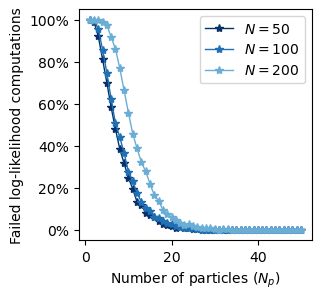

In [11]:
plt.figure(figsize=(3,3))
colors_track = mpl.colormaps['Blues'](np.linspace(0, 1, 5))[4:0:-1]
plt.plot(range(1,51), [save_for_varying_part_datadiv4[i][2]
                       for i in range(50)], '-*', color=colors_track[0], alpha=1.0,
         label=r'$N=50$', linewidth=1)
plt.plot(range(1,51), [save_for_varying_part_datadiv2[i][2]
                       for i in range(50)], '-*', color=colors_track[1], alpha=1.0,
         label=r'$N=100$', linewidth=1)
plt.plot(range(1,51), [save_for_varying_part[i][2]
                       for i in range(50)], '-*', color=colors_track[2], alpha=1.0,
         label=r'$N=200$', linewidth=1)
plt.legend()
plt.yticks([0,20,40,60,80,100], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xlabel(r'Number of particles ($N_p$)')
plt.ylabel('Failed log-likelihood computations')
plt.savefig("failed_loglikelihood_computations.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()

In [12]:
save_true_N_part50 = compare(T=60, init_seed=0, N_part=50, nr_iterations=1000)

Datapoints 200
N_part 50

pMCMC
Number of iterations 1000
Time required 246.9234938621521 seconds
[-1803.11892249 -1978.87082004 -1500.37015862 -2405.31514673
 -1558.59855661 -1948.47147815 -1510.91176636 -1443.18038676
 -1586.20463037 -1802.91676442 -1507.65494916 -2103.99899913
 -1473.9352375  -1544.07128089 -1632.45962644 -1688.37489216
 -1399.31245858 -1494.25879046 -1761.83877851 -1605.01701116
 -1871.33373946 -1894.13511839 -2348.38698233 -1413.24609282
 -1705.50409057 -1608.29166074 -1455.17626247 -1978.97868007
 -1862.83043302 -2425.04462301 -1418.55946524 -1283.3615092
 -1581.12391041 -1482.18200473 -2007.65117463 -1527.61115802
 -1494.89345319 -1413.83565687 -1964.24412712 -1325.36880503
 -1415.93486929 -1765.00127204 -1964.18478538 -1650.04219566
 -1605.03898112 -1414.80537596 -1366.96360611 -1444.53432949
 -1595.49057864 -2072.89514482 -2109.24545901 -1527.64319384
 -1431.1134543  -1493.28983193 -1449.45613828 -1414.32360129
 -1291.56363738 -1371.49301143 -1610.71311244 -14

In [13]:
save_true_N_part75 = compare(T=60, init_seed=0, N_part=75, nr_iterations=1000)

Datapoints 200
N_part 75

pMCMC
Number of iterations 1000
Time required 389.83992981910706 seconds
[-1291.60703217 -1338.60327487 -1266.86213382 -1339.71105502
 -1434.223477   -1302.72927445 -1321.12235485 -1335.27928312
 -1505.25894547 -1392.1247103  -1518.02399438 -1311.38417094
 -1331.38006448 -1483.05910351 -1290.25542847 -1407.84174625
 -1377.16700638 -1362.07387595 -1333.39338691 -1565.37728455
 -1367.07415088 -1448.28375409 -1375.81054803 -1261.18628672
 -1598.43969066 -1361.46872537 -1362.6927319  -1877.66372402
 -1586.5548157  -1338.01615136 -1350.06160631 -1322.20373251
 -1301.03362069 -1340.50036458 -1336.10215227 -1297.53787133
 -1460.58413077 -1344.24907233 -1354.91865934 -1390.37752453
 -1385.01358544 -1407.67619481 -1313.2073474  -1414.32928833
 -1299.66078914 -1270.49004497 -1360.2131662  -1307.4414697
 -1339.97415926 -1381.91605591 -1425.8773097  -1360.17805216
 -1277.23858136 -1323.45736632 -1325.09280535 -1340.0637585
 -1388.15167192 -1320.68153912 -1387.17476852 -13

In [14]:
save_true_N_part100 = compare(T=60, init_seed=0, N_part=100, nr_iterations=1000)

Datapoints 200
N_part 100

pMCMC
Number of iterations 1000
Time required 470.93364787101746 seconds
[-1301.09423482 -1324.64597855 -1262.52767337 -1289.38527466
 -1310.69504512 -1294.05028694 -1306.27854107 -1334.14839649
 -1339.611144   -1399.59623964 -1386.26421883 -1272.81306691
 -1302.56540091 -1298.41435325 -1251.6255342  -1277.56521542
 -1310.7699939  -1324.82577046 -1289.98344006 -1325.56676912
 -1300.3282193  -1428.88813645 -1273.11662248 -1267.92481496
 -1277.98313657 -1308.2232341  -1289.93033769 -1326.32819783
 -1421.2615783  -1329.33441952 -1439.35993698 -1306.83814704
 -1288.81064869 -1308.80495057 -1352.00523437 -1292.54546536
 -1333.1631871  -1262.5287315  -1323.24177617 -1268.77752834
 -1389.65778752 -1342.56932729 -1290.10562461 -1376.01376495
 -1416.00448654 -1261.39435846 -1289.77203281 -1310.18964476
 -1291.68048436 -1409.24115106 -1264.73860992 -1367.51313368
 -1308.3502056  -1382.83671085 -1261.99006109 -1300.31063456
 -1325.85386846 -1262.04755101 -1328.03560851 

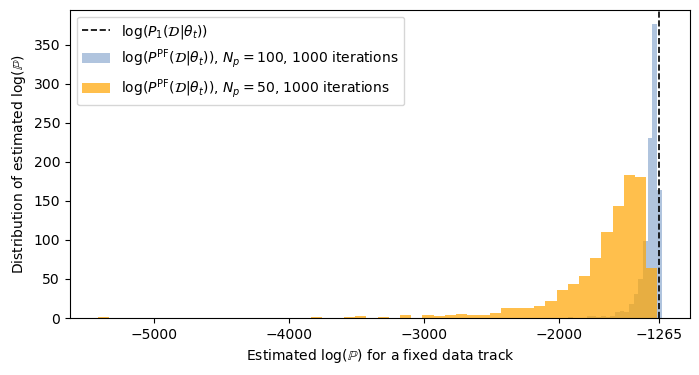

In [15]:
plt.figure(figsize=(8,4))

plt.axvline(save_true_N_part100[1], linestyle='--', linewidth=1.2, color='black', label=r'log($P_1(\mathcal{D}|\theta_t)$)')

plt.hist(save_true_N_part100[0], bins=20, color='lightsteelblue', label=r'log($P^{\mathrm{PF}}(\mathcal{D}|\theta_t)$), $N_p=100$, 1000 iterations')

plt.hist(save_true_N_part50[0], bins=50, color='orange', alpha=0.7, label=r'log($P^{\mathrm{PF}}(\mathcal{D}|\theta_t)$), $N_p=50$, 1000 iterations')

plt.legend()
plt.ylabel(r'Distribution of estimated log($\mathbb{P}$)')
plt.xlabel(r'Estimated log($\mathbb{P}$) for a fixed data track')
plt.xticks([-5000, -4000, -3000, -2000, save_true_N_part100[1]])

plt.savefig("estimated_loglikelihood.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()

In [16]:
TimespMCMC_N_part50 = []
Timestrack_N_part50 = []
for i in range(100):
    Times = compare_time(T=60, init_seed=i, N_part=50, nr_iterations=1)
    TimespMCMC_N_part50.append(copy.deepcopy(Times[0]))
    Timestrack_N_part50.append(copy.deepcopy(Times[1]))
    
print(TimespMCMC_N_part50, Timestrack_N_part50)

print('Avg times:')
print(np.mean(TimespMCMC_N_part50), np.mean(Timestrack_N_part50))

Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23917603492736816 seconds
Runtime 0.09248995780944824 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.24203109741210938 seconds
Runtime 0.09760189056396484 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23955488204956055 seconds
Runtime 0.09318399429321289 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.2389371395111084 seconds
Runtime 0.09283208847045898 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.24182486534118652 seconds
Runtime 0.09474587440490723 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.24809694290161133 seconds
Runtime 0.0941619873046875 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.2359631061553955 seconds
Runtime 0.0930938720703125 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23769712448120117 seconds
Runtime 0.09723901748657227 seco

Runtime 0.09266114234924316 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.22928214073181152 seconds
Runtime 0.09657597541809082 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.2416822910308838 seconds
Runtime 0.09157586097717285 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23401093482971191 seconds
Runtime 0.09281182289123535 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.22777295112609863 seconds
Runtime 0.09687685966491699 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.24002885818481445 seconds
Runtime 0.09390068054199219 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23858380317687988 seconds
Runtime 0.09447765350341797 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.22665786743164062 seconds
Runtime 0.09486198425292969 seconds
Datapoints 200
N_part 50
Number of iterations 1
Time required 0.23070096969604492 s

In [17]:
TimespMCMC_N_part100 = []
Timestrack_N_part100 = []
for i in range(100):
    Times = compare_time(T=60, init_seed=i, N_part=100, nr_iterations=1)
    TimespMCMC_N_part100.append(copy.deepcopy(Times[0]))
    Timestrack_N_part100.append(copy.deepcopy(Times[1]))
    
print(TimespMCMC_N_part100, Timestrack_N_part100)

print('Avg times:')
print(np.mean(TimespMCMC_N_part100), np.mean(Timestrack_N_part100))

Datapoints 200
N_part 100
Number of iterations 1
Time required 0.48680901527404785 seconds
Runtime 0.09235906600952148 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4844169616699219 seconds
Runtime 0.0954737663269043 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.49892520904541016 seconds
Runtime 0.09737992286682129 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4909238815307617 seconds
Runtime 0.09333682060241699 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4934518337249756 seconds
Runtime 0.09231996536254883 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4708089828491211 seconds
Runtime 0.09444499015808105 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4632391929626465 seconds
Runtime 0.09666180610656738 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4598357677459717 seconds
Runtime 0.09246110916137695

Time required 0.4759969711303711 seconds
Runtime 0.09608292579650879 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.47643280029296875 seconds
Runtime 0.09245181083679199 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.46652793884277344 seconds
Runtime 0.0930790901184082 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4598422050476074 seconds
Runtime 0.09308791160583496 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.4757204055786133 seconds
Runtime 0.09343481063842773 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.46399712562561035 seconds
Runtime 0.09381890296936035 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.45716094970703125 seconds
Runtime 0.0931692123413086 seconds
Datapoints 200
N_part 100
Number of iterations 1
Time required 0.46224522590637207 seconds
Runtime 0.09477400779724121 seconds
Datapoints 200
N_part 100
Number of it

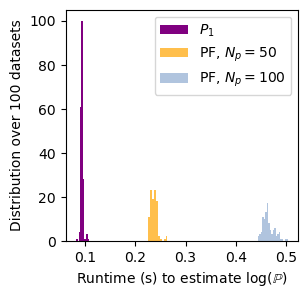

In [18]:
plt.figure(figsize=(3,3))

plt.hist(Timestrack_N_part50+Timestrack_N_part100, bins=10, color='purple', label=r'$P_1$')
plt.hist(TimespMCMC_N_part50, bins=10, color='orange', alpha=0.7, label=r'PF, $N_p=50$')
plt.hist(TimespMCMC_N_part100, bins=20, color='lightsteelblue', label=r'PF, $N_p=100$')
plt.xlabel(r'Runtime (s) to estimate log($\mathbb{P}$)')
plt.ylabel('Distribution over 100 datasets')
plt.legend()
plt.savefig("runtime_comparison.png", format="png", dpi=1200,
            bbox_inches="tight")
plt.show()
#avg time P1 is 0.11s
#avg time PF N_p=50 is 0.27s
#avg time PF N_p=100 is 0.54s (doubles compared to N_p = 50)